In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

"""
グラフやフォント等の設定bbbbbbbbhb
"""
plt.style.use('seaborn-bright')
plt.rcParams['font.family'] = 'Times New Roman'  # 全体のフォント
#plt.rcParams['font.family'] = 'IPAexGothic'  # 全体のフォントを設定 (日本語表示の場合に追加)

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.default'] = 'it'   # 数式で通常使用するフォント．

""" Macbook ProでのPython 3.7系用に微調整 (EMC Europe 2019原稿から)"""

""""""
###############################################################
"""メイン関数"""
if __name__ == '__main__':
    
    
    Radius_j = np.arange(15.5,17.5,0.1)
    theta_i = np.arange(20,40)
    
    
    
    #test    
    #z = np.zeros((2,2))
    #Radius_j = np.arange(14.5,14.7,0.1)
    #theta_i = np.arange(20,22)
    
    z = np.zeros((len(Radius_j),len(theta_i)))
    z2= np.zeros((len(Radius_j),len(theta_i)))
    print(z.shape)
    
    
    z_x = -1
    for j in Radius_j:
        Radius = round(j,1)
        
        z_x += 1
       
        for i in theta_i:
            
            Theta_ang = i

            Theta_rad =np.pi/180*Theta_ang
            Delay_diff = Radius*Theta_rad
            Alt_Lengs1 = Radius*(np.pi - Theta_rad)
            Alt_Lengs2 = Radius*(np.pi + Theta_rad)
            #print(str(Alt_Lengs1)+'-'+str(Alt_Lengs2))



            # 解析周波数範囲
            delta_f = 0.0001e9
            fmin = 2.0e9
            fmax = 4.0e9

            # 配列の初期化 [周波数軸]
            freq = np.arange(fmin, fmax, delta_f)
            freq2 = freq[0:(len(freq) - 1)] + np.diff(freq) / 2.0

            # 配列の初期化 [S21, A]
            freqS21mag = np.zeros([len(freq), 2])
            freqS21phase = np.zeros([len(freq), 2])
            freqS21phase2 = np.zeros([len(freq), 2])
            freqHRmag = np.zeros([len(freq), 2])
            freqHRphase = np.zeros([len(freq), 2])
            freqHRphase2 = np.zeros([len(freq), 2])

            freqS21mag[:, 0] = freq
            freqS21phase[:, 0] = freq
            freqS21phase2[:, 0] = freq
            freqHRmag[:, 0] = freq
            freqHRphase[:, 0] = freq
            freqHRphase2[:, 0] = freq

            # 伝送線路全体での損失 [in dB]
            alpha_tgt = 0.3

            # 伝送線路条件
            # LC: p.578の条件から計算
            # Lengs: 論文中の物理長では共振点がズレたので，伝搬速度と遅延時間から逆算
            # 抵抗値: 損失をシリーズ抵抗のみで表現
            """ 線路 1 """
            Cs1 = 7.79498e-11
            Ls1 = 4.00713e-7
            Z1 = np.sqrt(Ls1 / Cs1)
            vp1 = 1.0 / np.sqrt(Ls1 * Cs1)
            Lengs1 = Alt_Lengs1*1.0e-3
            #Lengs1 = vp1 * 0.26e-9
            Rs1 = alpha_tgt * 2 * Z1 / (8.686 * Lengs1)

            """ 線路 2 """
            Cs2 = 7.79498e-11
            Ls2 = 4.00713e-7
            Z2 = np.sqrt(Ls2 / Cs2)
            vp2 = 1.0 / np.sqrt(Ls2 * Cs2)
            Lengs2 = Alt_Lengs2*1.0e-3
            #Lengs2 = vp2 * 0.28e-9
            Rs2 = alpha_tgt * 2 * Z2 / (8.686 * Lengs2)

            #print(Rs2)
            #print("t1="+str(Lengs1/vp1),"t2="+str(Lengs2/vp2),'sum='+str(Lengs1/vp1+Lengs2/vp2))
            # 周波数特性の算出
            for n in range(0, len(freq)):

                # 線路1のF行列 => Y行列
                gamma1 = Rs1 / (2.0 * Z1) + 2.0j * np.pi * freq[n] * np.sqrt(Ls1 * Cs1)
                Z1 = np.sqrt(Ls1 / Cs1)
                F1 = np.array([[np.cosh(gamma1 * Lengs1), 1.0 * Z1 * np.sinh(gamma1 * Lengs1)], [1.0 / Z1 * np.sinh(gamma1 * Lengs1), np.cosh(gamma1 * Lengs1)]])
                A1, B1, C1, D1 = F1[0, 0], F1[0, 1], F1[1, 0], F1[1, 1]
                Y1 = np.array([[D1 / B1, -(A1 * D1 - B1 * C1) / B1], [-1.0 / B1, A1 / B1]])

                # 線路2のF行列 => Y行列
                gamma2 = Rs2 / (2.0 * Z2) + 2.0j * np.pi * freq[n] * np.sqrt(Ls2 * Cs2)
                Z2 = np.sqrt(Ls2 / Cs2)
                F2 = np.array([[np.cosh(gamma2 * Lengs2), 1.0 * Z2 * np.sinh(gamma2 * Lengs2)], [1.0 / Z2 * np.sinh(gamma2 * Lengs2), np.cosh(gamma2 * Lengs2)]])
                A2, B2, C2, D2 = F2[0, 0], F2[0, 1], F2[1, 0], F2[1, 1]
                Y2 = np.array([[D2 / B2, -(A2 * D2 - B2 * C2) / B2], [-1.0 / B2, A2 / B2]])

                # 並列線路全体のY行列 ==> Sパラ, Fパラ
                Ymtx = Y1 + Y2
                U = np.eye(2)
                Spara = np.dot((U - 50.0 * Ymtx), np.linalg.inv(U + 50.0 * Ymtx))
                # 必要な成分(S21)の抽出 (Pythonでは添え字の範囲が0からなので要注意 !!!)
                freqS21mag[n, 1] = 20.0 * np.log10(np.abs(Spara[1, 0]))
                freqS21phase[n, 1] = np.angle(Spara[1, 0])
                HR = Spara[1, 0] / (1.0 + Spara[0, 0])
                freqHRmag[n, 1] = 20.0 * np.log10(np.abs(HR))
                freqHRphase[n, 1] = np.angle(HR)


            ###############################################################
            # データ処理（位相接続して，群遅延を算出）
            ###############################################################
            pc = 0
            for xyz in range(1, len(freq)):
                if freqS21phase[xyz, 1] - freqS21phase[xyz - 1, 1] > np.pi / 2.0:
                    pc = pc - 2
                if freqS21phase[xyz, 1] - freqS21phase[xyz - 1, 1] < -np.pi / 2.0:
                    pc = pc + 2
                freqS21phase2[xyz, 1] = freqS21phase[xyz, 1] + np.pi * pc
            pc = 0
            for xyz in range(1, len(freq)):
                if freqHRphase[xyz, 1] - freqHRphase[xyz - 1, 1] > np.pi / 2.0:
                    pc = pc - 2
                if freqHRphase[xyz, 1] - freqHRphase[xyz - 1, 1] < -np.pi / 2.0:
                    pc = pc + 2
                freqHRphase2[xyz, 1] = freqHRphase[xyz, 1] + np.pi * pc

            freqS21groupdelay = -1.0 / 360.0 * np.diff(freqS21phase2[:, 1]) / np.diff(freq) * 180.0 / np.pi * 1.0e9
            freqHRgroupdelay = -1.0 / 360.0 * np.diff(freqHRphase2[:, 1]) / np.diff(freq) * 180.0 / np.pi * 1.0e9

            SGmin=np.min(freqS21groupdelay[1:])
            Smin = np.min(freqS21mag[1:])
            centerfreq=np.argmin(freqS21groupdelay[1:])*0.0001e9+fmin
            colum = str(Radius)+'-'+str(Theta_ang)
        
            
            
            z_y = i -theta_i[0]
            
            
            print(str(Radius)+"-"+str(i))
            print(centerfreq)
            print(SGmin)
            print('z_x',z_x)
            print('z_y',z_y)
            z[z_x,z_y] = centerfreq
            z2[z_x,z_y] = SGmin
            #print(z)

    
     
    x,y = np.meshgrid(Radius_j,theta_i)
    
    print(z)
    print(z2)
    print(x.shape)
    print(y.shape)
 
    #printは動作確認のためにつけています邪魔だったら消してください
    

(20, 20)
15.5-20
3674300000.0
-6.291671004338448
z_x 0
z_y 0
15.5-21
3674300000.0
-6.392071345698431
z_x 0
z_y 1
15.5-22
3674300000.0
-6.4811656208011605
z_x 0
z_y 2
15.5-23
3674300000.0
-6.5603925731029555
z_x 0
z_y 3
15.5-24
3674300000.0
-6.630978589024009
z_x 0
z_y 4
15.5-25
3674300000.0
-6.69397015799067
z_x 0
z_y 5
15.5-26
3674300000.0
-6.7502615579110365
z_x 0
z_y 6
15.5-27
3674300000.0
-6.800618264591878
z_x 0
z_y 7
15.5-28
3674300000.0
-6.845696637810048
z_x 0
z_y 8
15.5-29
3674300000.0
-6.886060422069083
z_x 0
z_y 9
15.5-30
3674300000.0
-6.9221945523641395
z_x 0
z_y 10
15.5-31
3674300000.0
-6.954516696428978
z_x 0
z_y 11
15.5-32
3674300000.0
-6.983386902486367
z_x 0
z_y 12
15.5-33
3674300000.0
-7.009115664371393
z_x 0
z_y 13
15.5-34
3674300000.0
-7.031970665746435
z_x 0
z_y 14
15.5-35
3674300000.0
-7.052182419766012
z_x 0
z_y 15
15.5-36
3674300000.0
-7.069948983034819
z_x 0
z_y 16
15.5-37
3674300000.0
-7.085439892102526
z_x 0
z_y 17
15.5-38
3674300000.0
-7.098799442446009
z_x 

16.2-36
3515600000.0
-7.389193612606075
z_x 7
z_y 16
16.2-37
3515500000.0
-7.405382288211088
z_x 7
z_y 17
16.2-38
3515500000.0
-7.419346219978724
z_x 7
z_y 18
16.2-39
3515500000.0
-7.431209810084921
z_x 7
z_y 19
16.3-20
3494000000.0
-6.616443222521647
z_x 8
z_y 0
16.3-21
3494000000.0
-6.7220218532385365
z_x 8
z_y 1
16.3-22
3494000000.0
-6.815711130096434
z_x 8
z_y 2
16.3-23
3494000000.0
-6.899024037994832
z_x 8
z_y 3
16.3-24
3494000000.0
-6.973250242790797
z_x 8
z_y 4
16.3-25
3494000000.0
-7.039490227590832
z_x 8
z_y 5
16.3-26
3494000000.0
-7.0986844080239795
z_x 8
z_y 6
16.3-27
3494000000.0
-7.151637750413471
z_x 8
z_y 7
16.3-28
3494000000.0
-7.199040474065083
z_x 8
z_y 8
16.3-29
3494000000.0
-7.241485403643383
z_x 8
z_y 9
16.3-30
3494000000.0
-7.279482487804052
z_x 8
z_y 10
16.3-31
3494000000.0
-7.3134709370117825
z_x 8
z_y 11
16.3-32
3494000000.0
-7.343829369013741
z_x 8
z_y 12
16.3-33
3494000000.0
-7.370884290422701
z_x 8
z_y 13
16.3-34
3494000000.0
-7.3949171886183365
z_x 8
z_y 14

17.0-30
3350100000.0
-7.592096834090086
z_x 15
z_y 10
17.0-31
3350100000.0
-7.6275460999884555
z_x 15
z_y 11
17.0-32
3350100000.0
-7.659209405816575
z_x 15
z_y 12
17.0-33
3350100000.0
-7.687427287689064
z_x 15
z_y 13
17.0-34
3350100000.0
-7.7124933290281135
z_x 15
z_y 14
17.0-35
3350100000.0
-7.734660345698316
z_x 15
z_y 15
17.0-36
3350100000.0
-7.754145556383265
z_x 15
z_y 16
17.0-37
3350100000.0
-7.77113489957398
z_x 15
z_y 17
17.0-38
3350100000.0
-7.785786630333586
z_x 15
z_y 18
17.0-39
3350100000.0
-7.798234304405556
z_x 15
z_y 19
17.1-20
3330500000.0
-6.9411458692776185
z_x 16
z_y 0
17.1-21
3330500000.0
-7.051909316672694
z_x 16
z_y 1
17.1-22
3330500000.0
-7.150199674410695
z_x 16
z_y 2
17.1-23
3330500000.0
-7.23760419791356
z_x 16
z_y 3
17.1-24
3330500000.0
-7.3154758646329405
z_x 16
z_y 4
17.1-25
3330500000.0
-7.384969184671459
z_x 16
z_y 5
17.1-26
3330500000.0
-7.447070744464981
z_x 16
z_y 6
17.1-27
3330500000.0
-7.502625032929291
z_x 16
z_y 7
17.1-28
3330500000.0
-7.5523561593

In [3]:
df_z = pd.DataFrame(z,columns=theta_i,index = Radius_j)
df_z2= pd.DataFrame(z2,columns=theta_i,index = Radius_j)

df_z.to_csv('cf1125.csv')
df_z2.to_csv('ngd1125.csv')

<IPython.core.display.Javascript object>


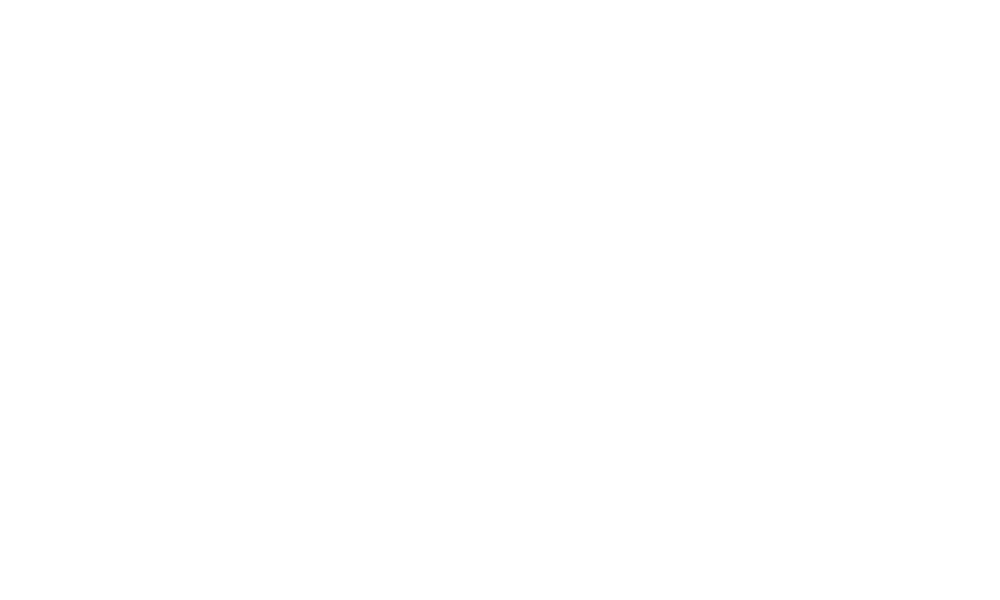

<IPython.core.display.Javascript object>


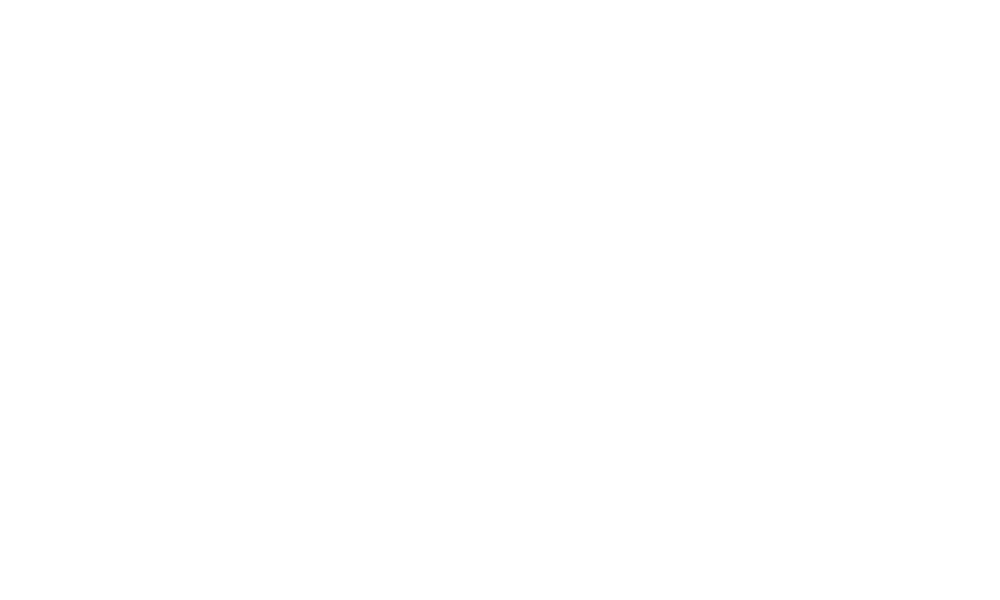

<IPython.core.display.Javascript object>


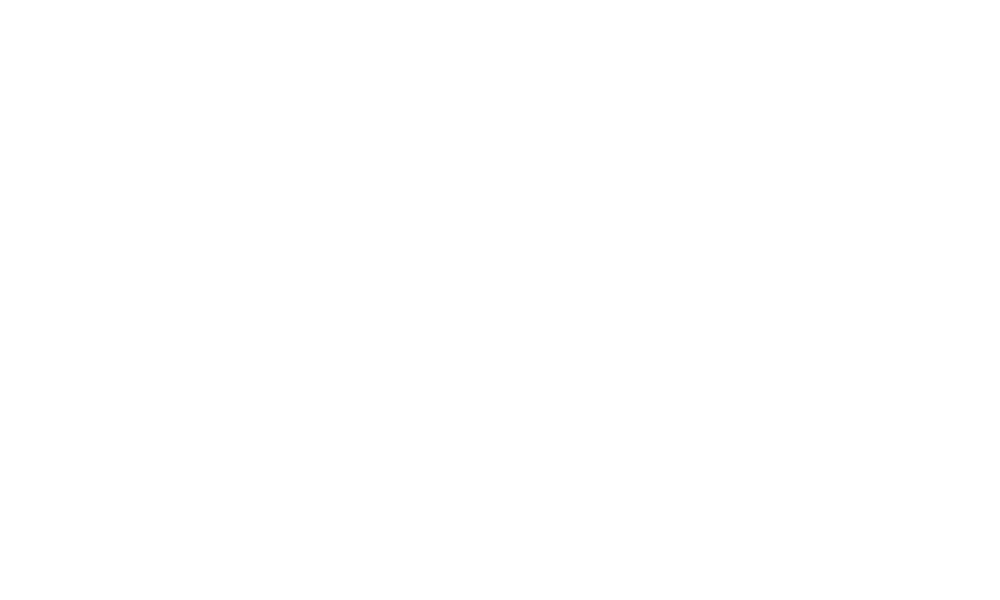

<IPython.core.display.Javascript object>


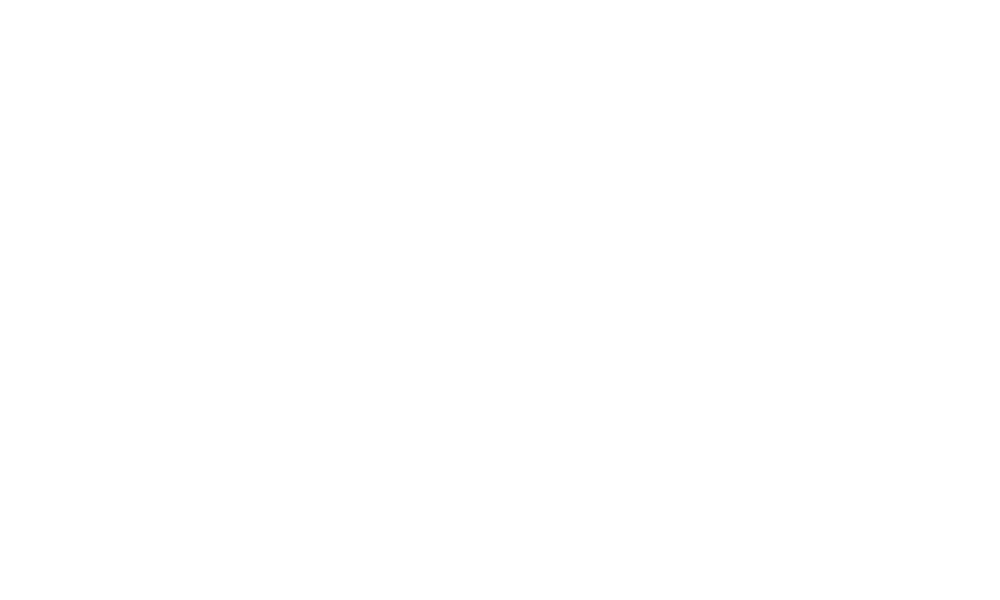

<IPython.core.display.Javascript object>


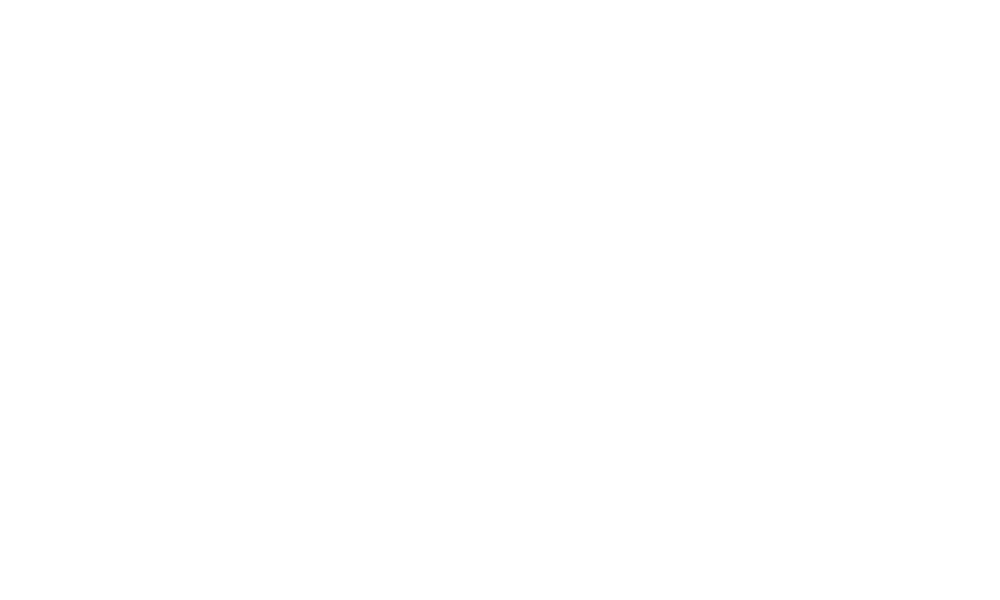

<IPython.core.display.Javascript object>


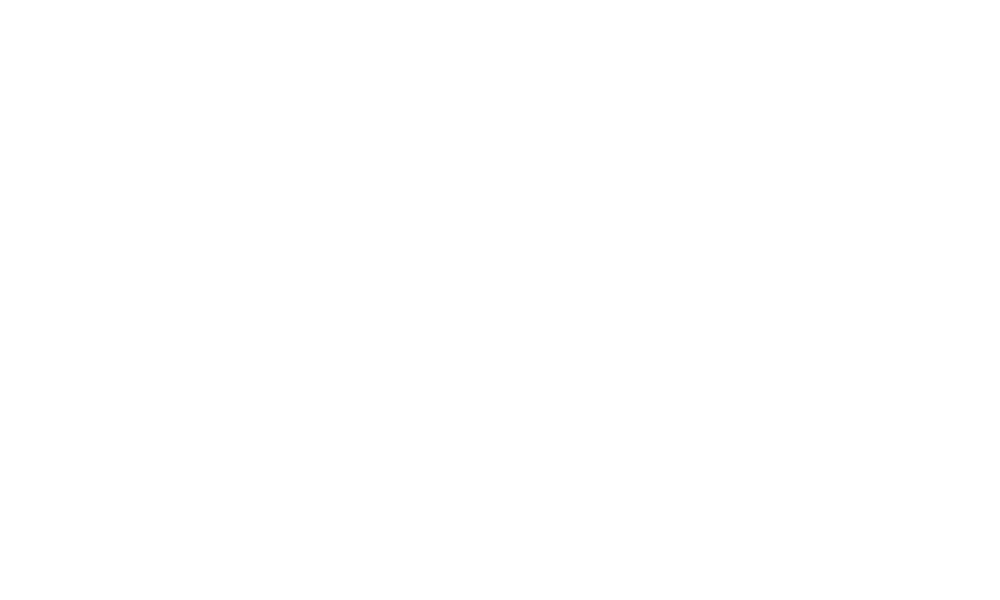

<IPython.core.display.Javascript object>


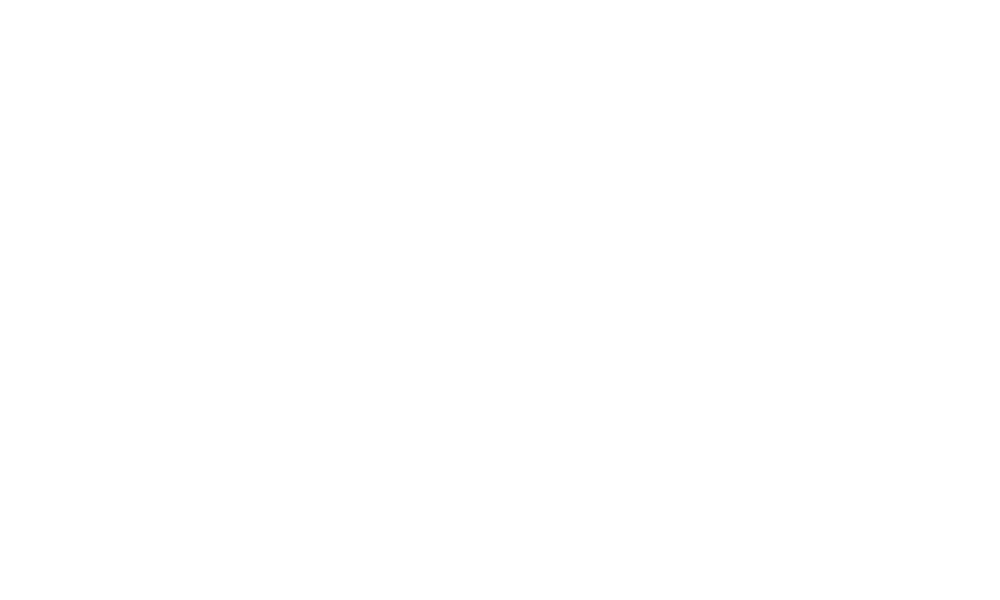

<IPython.core.display.Javascript object>


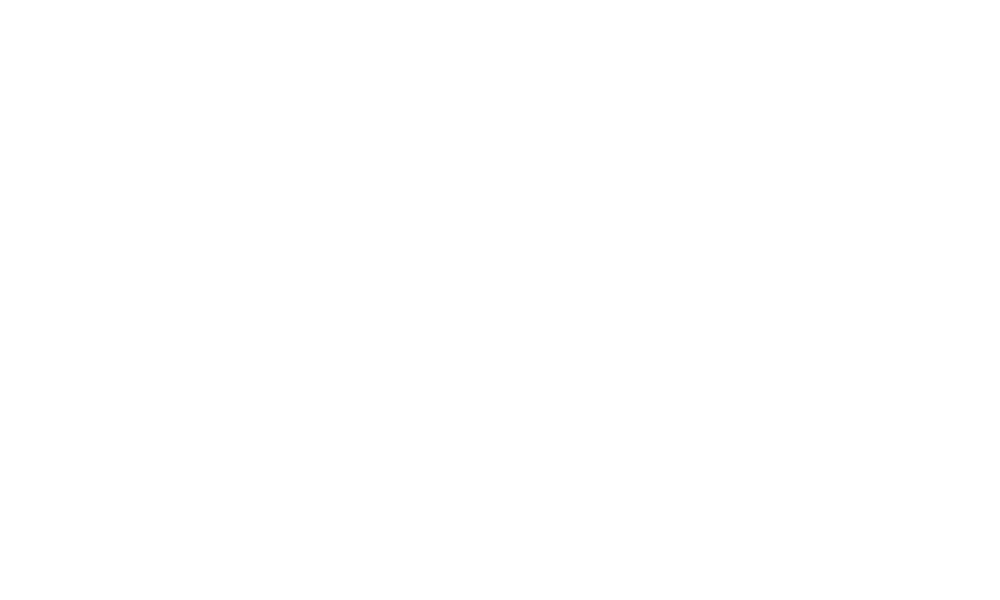

<IPython.core.display.Javascript object>


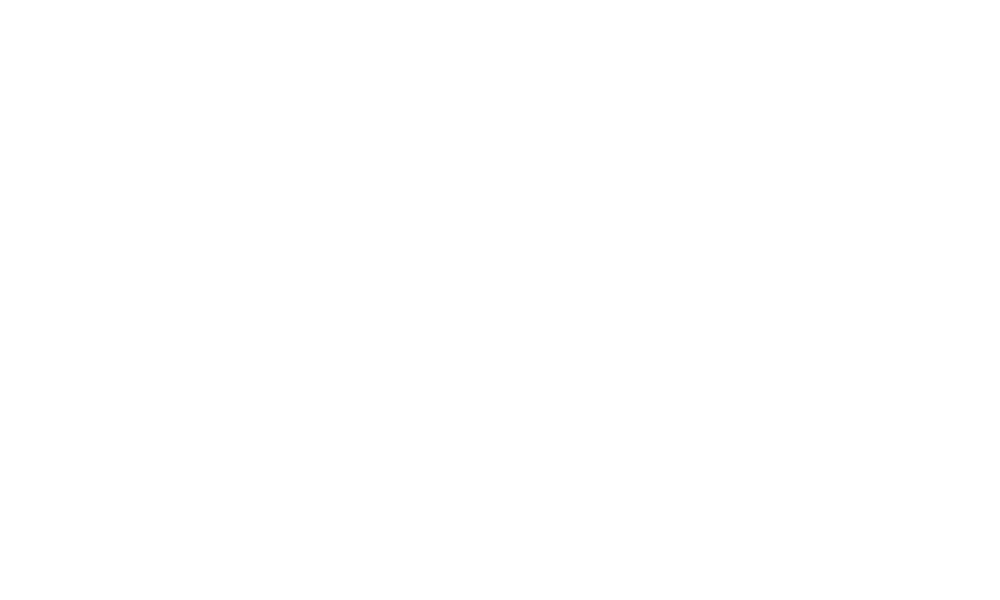

<IPython.core.display.Javascript object>


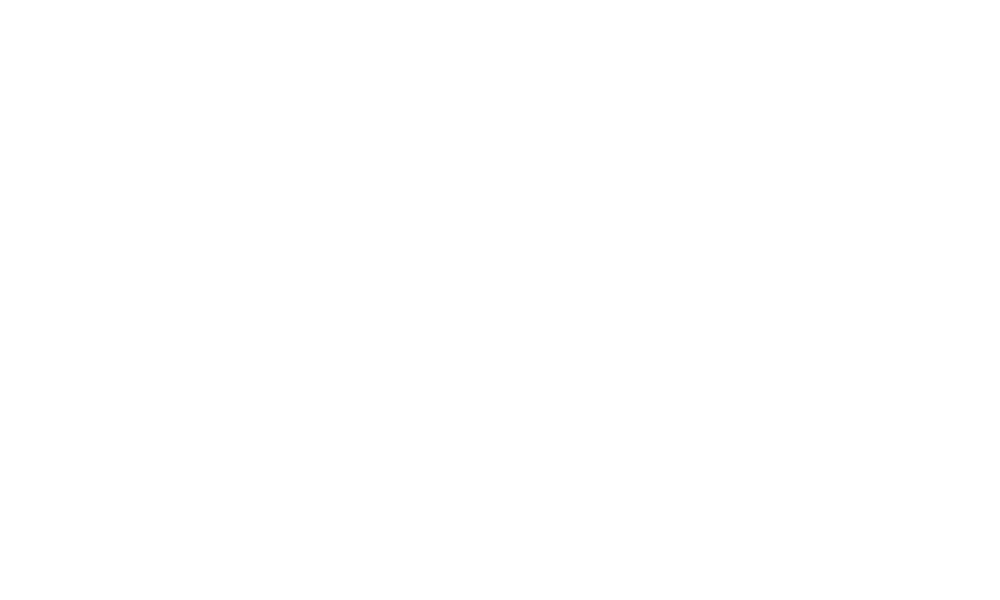

<IPython.core.display.Javascript object>


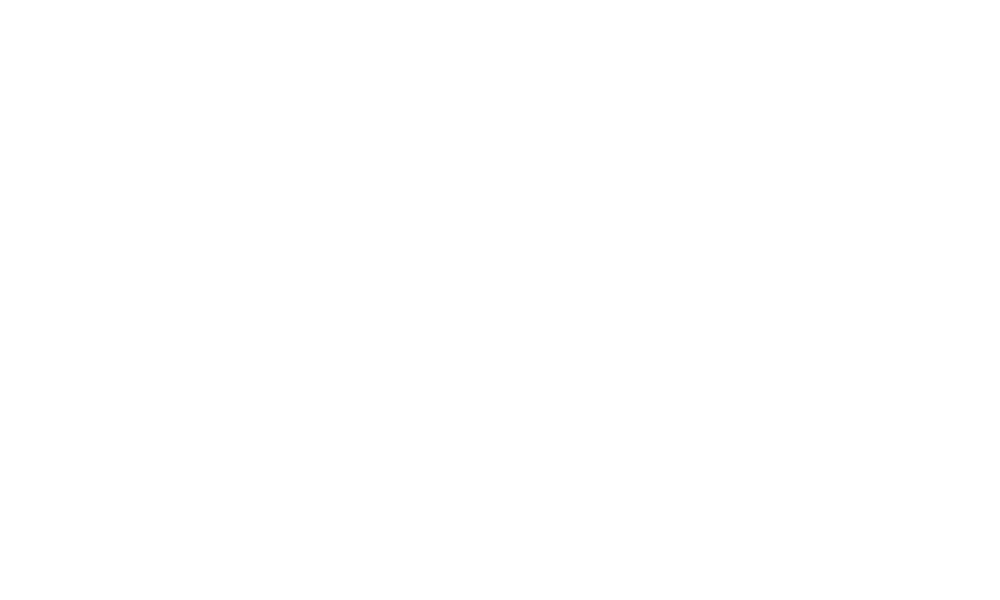

<IPython.core.display.Javascript object>


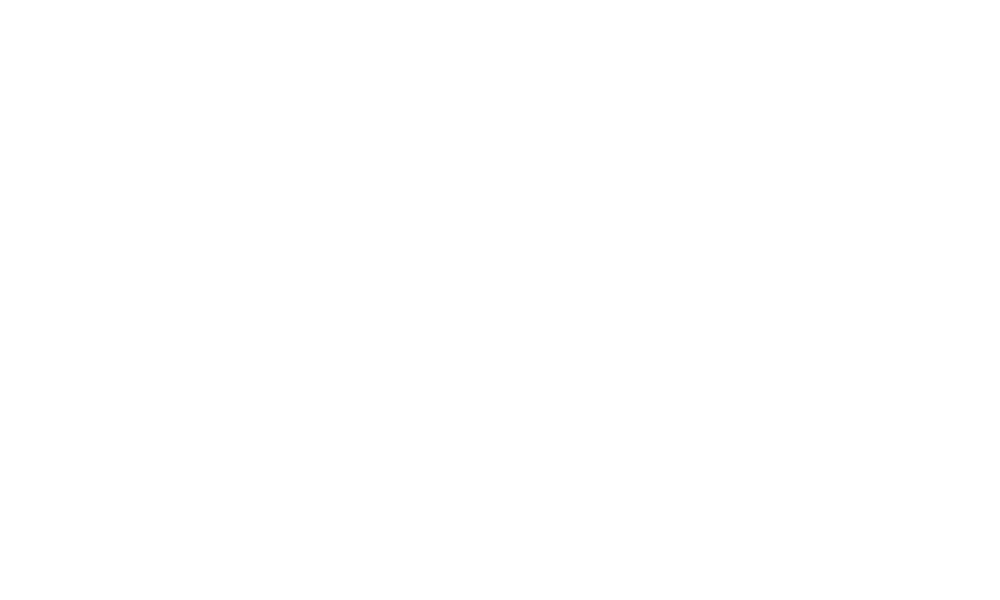

<IPython.core.display.Javascript object>


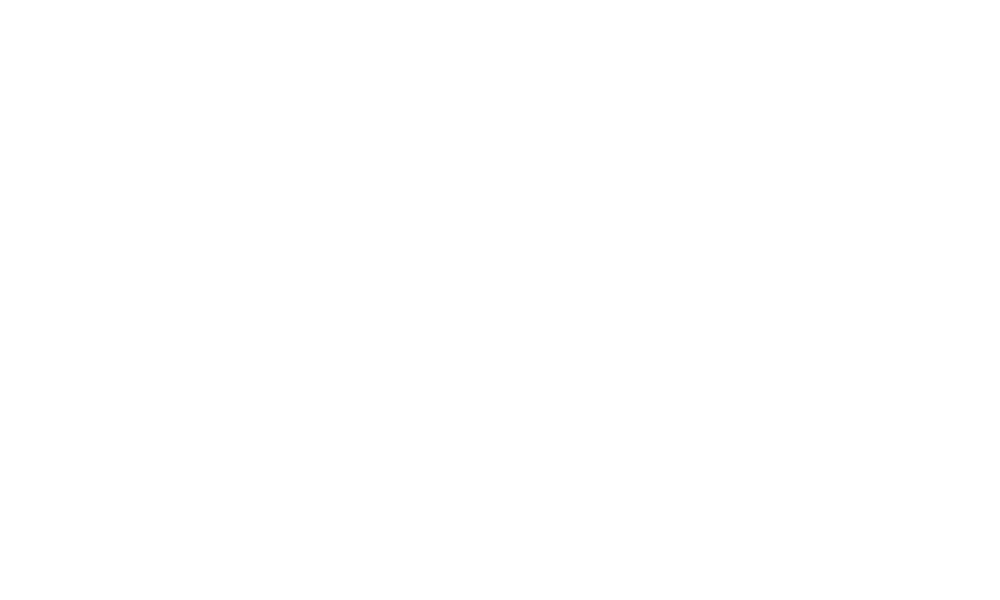

<IPython.core.display.Javascript object>


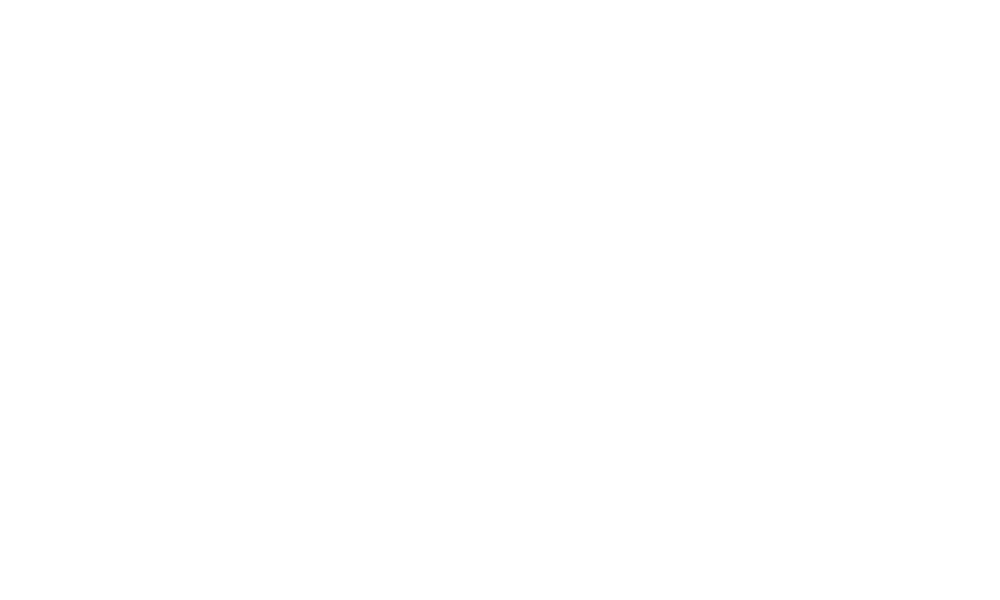

<IPython.core.display.Javascript object>


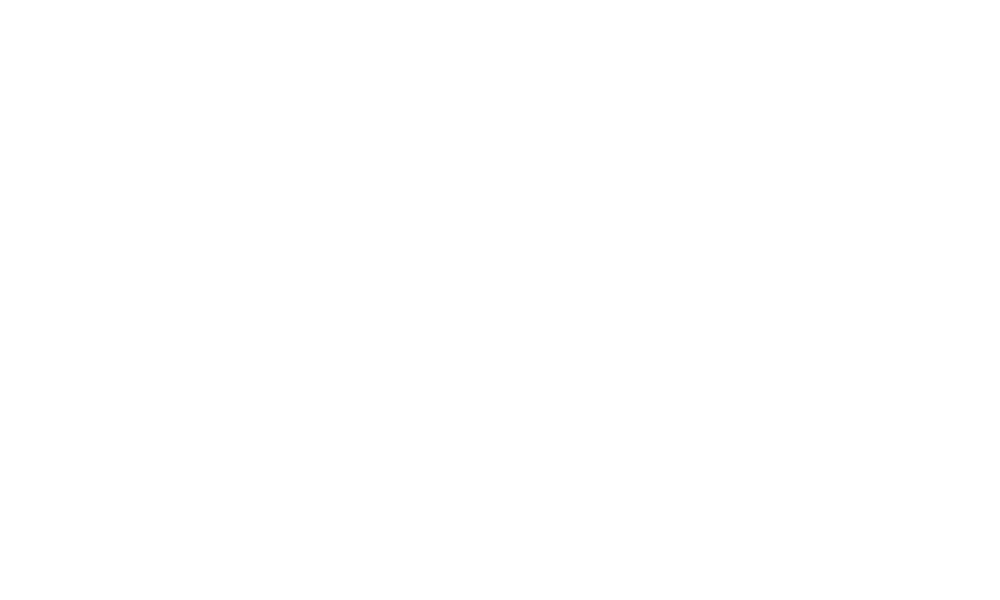

<IPython.core.display.Javascript object>


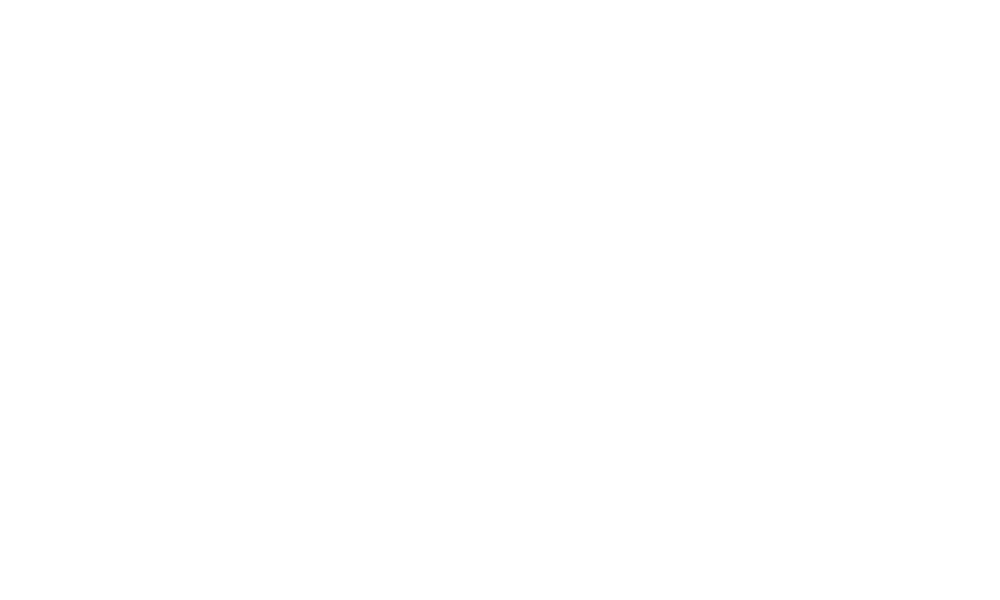

<IPython.core.display.Javascript object>


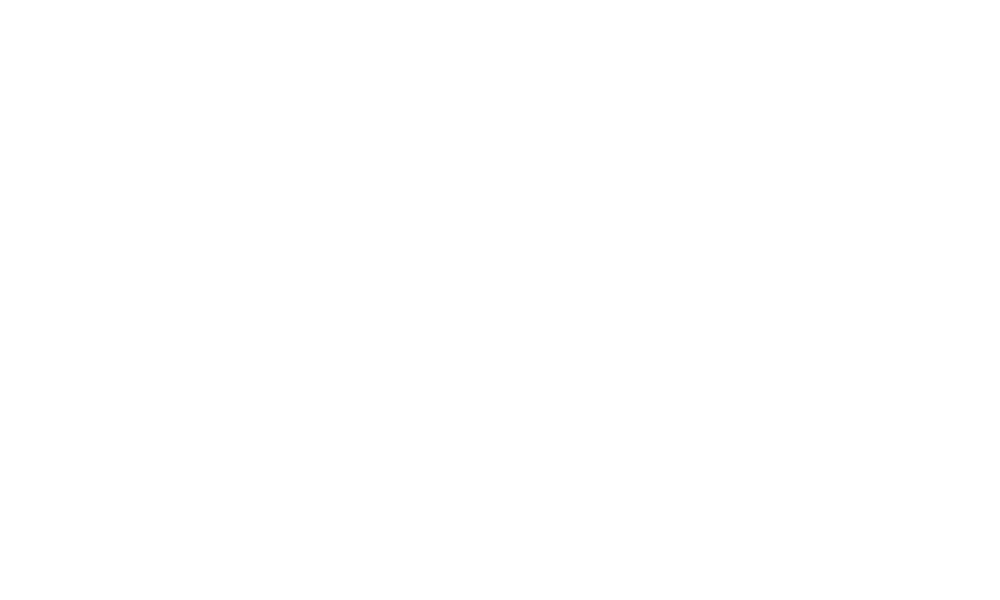

<IPython.core.display.Javascript object>


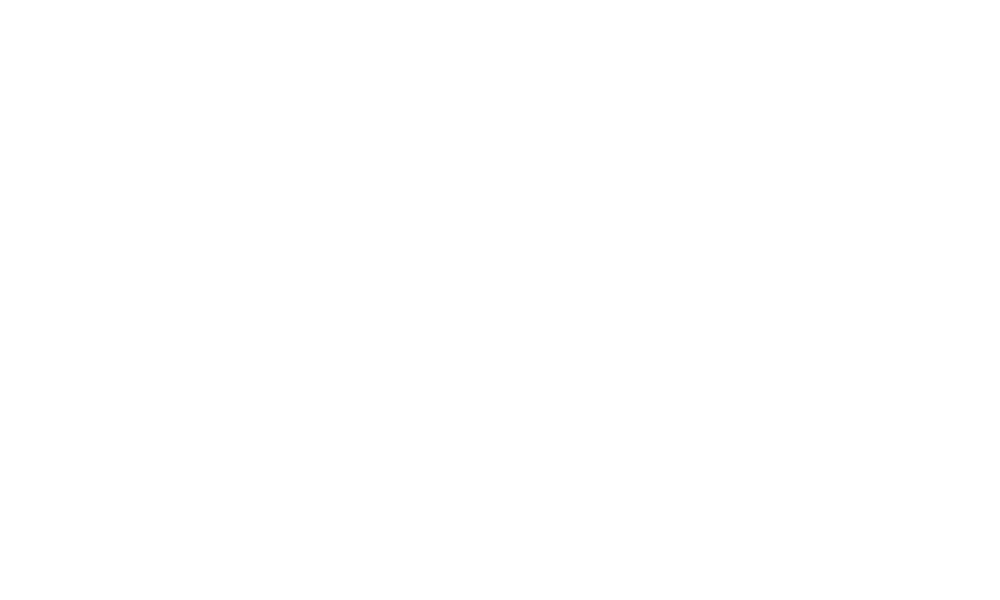

<IPython.core.display.Javascript object>


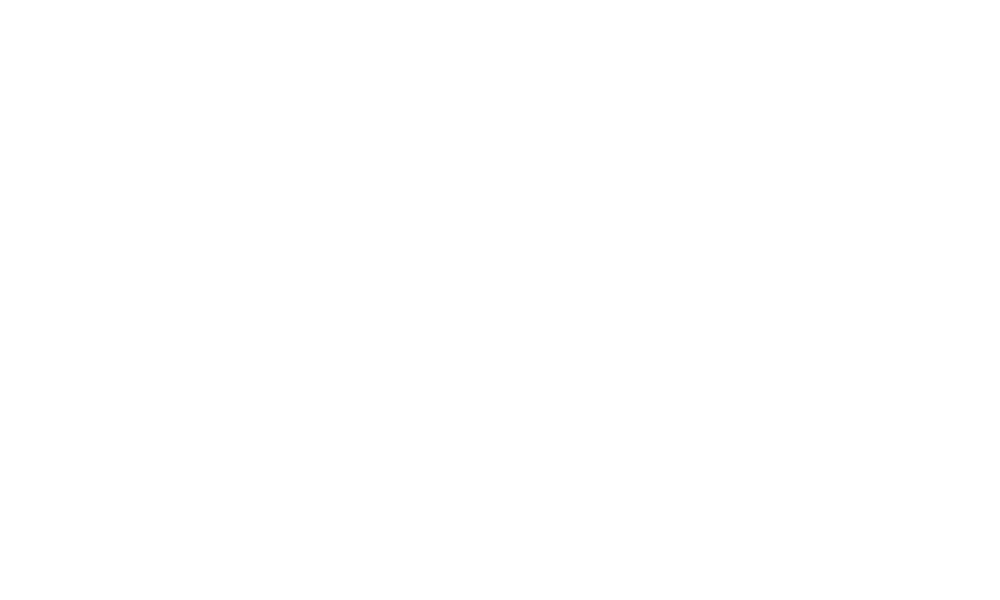

<IPython.core.display.Javascript object>


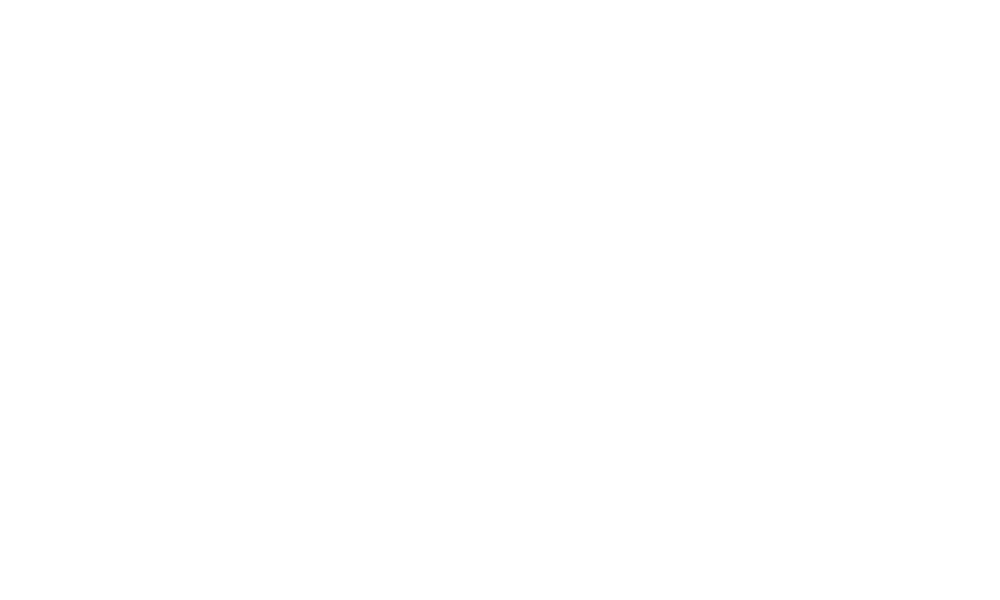

<IPython.core.display.Javascript object>


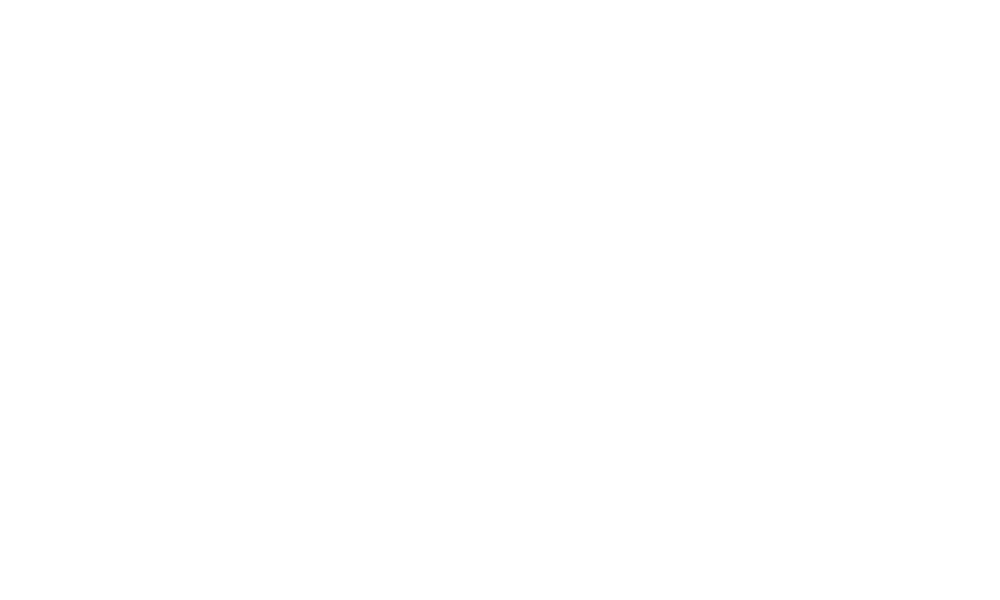

<IPython.core.display.Javascript object>


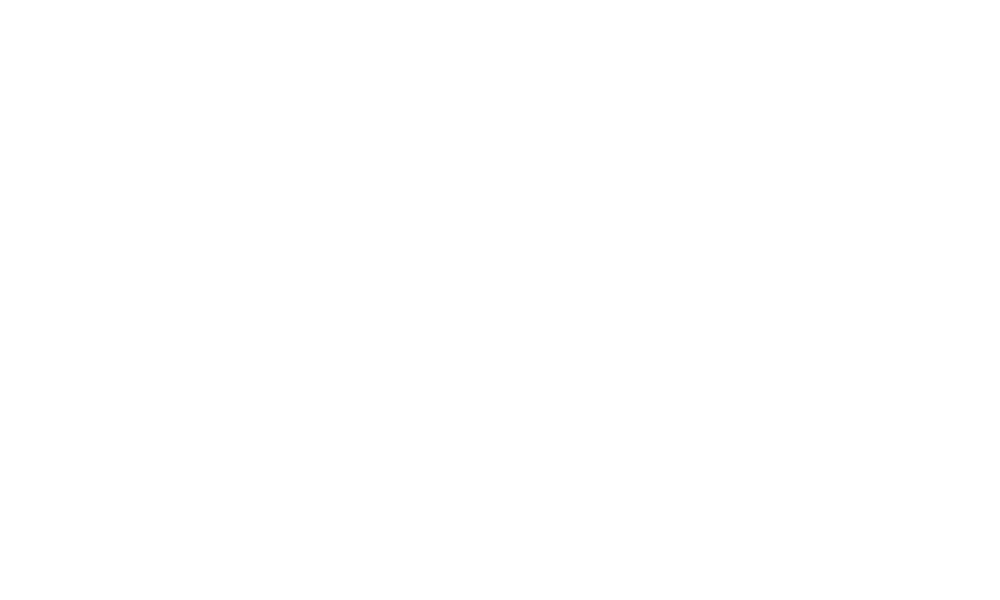

<IPython.core.display.Javascript object>


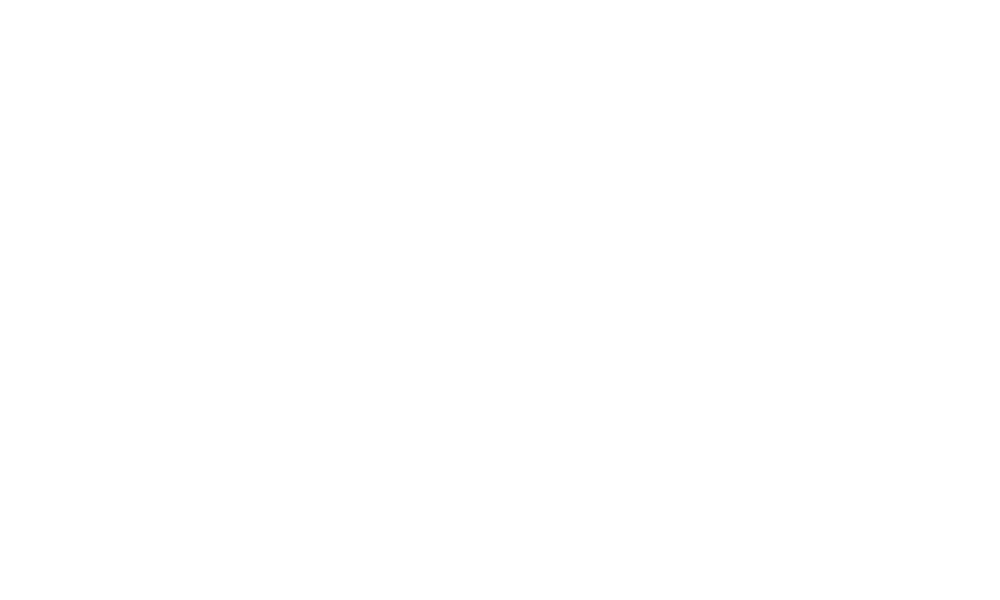

<IPython.core.display.Javascript object>


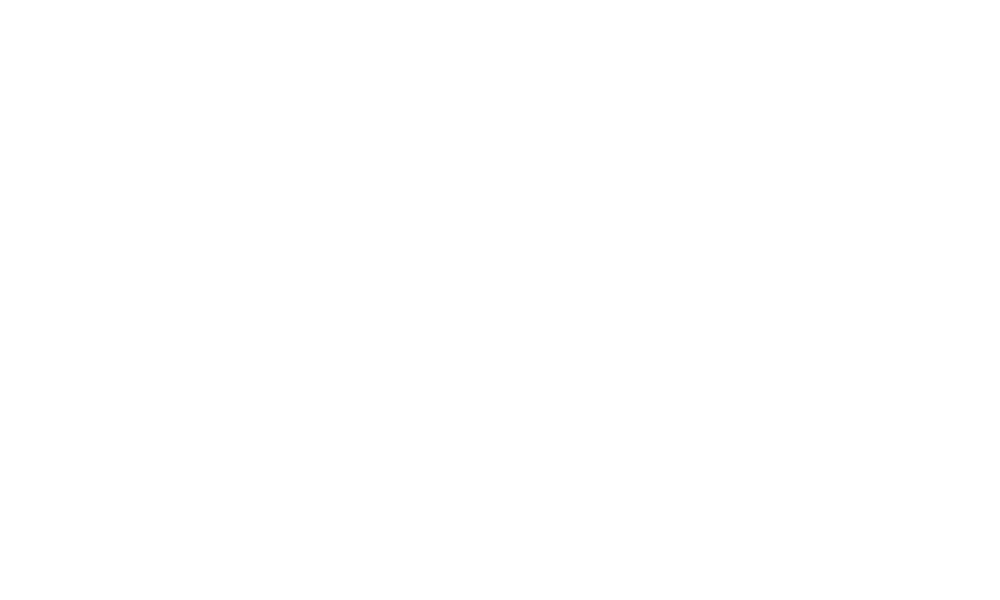

<IPython.core.display.Javascript object>


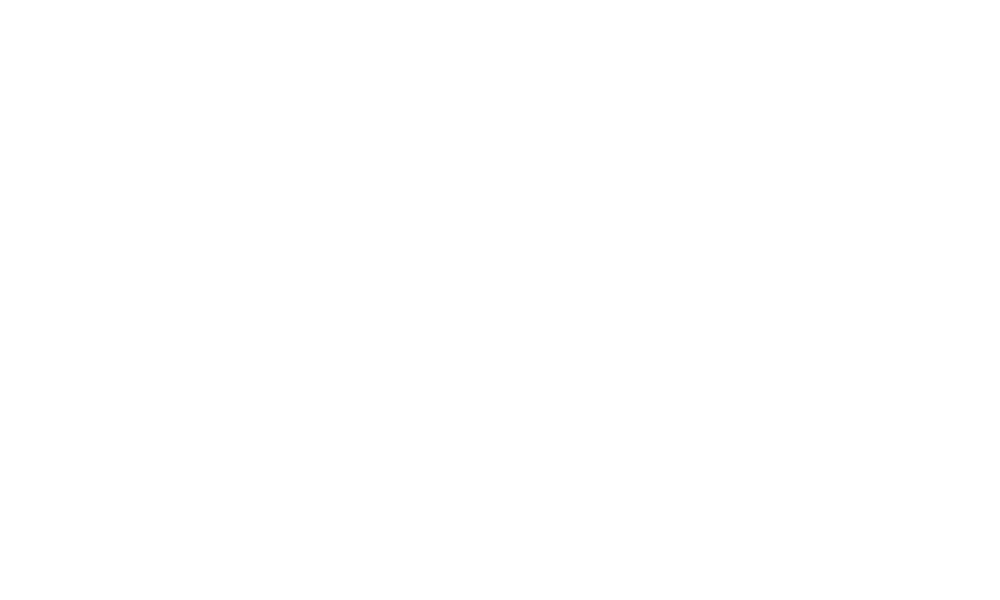

<IPython.core.display.Javascript object>


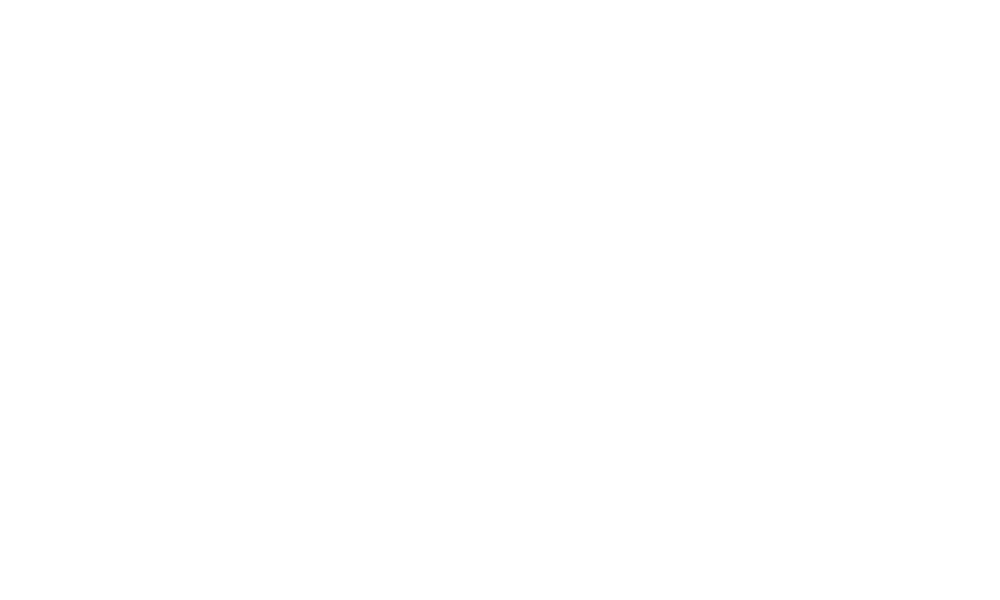

<IPython.core.display.Javascript object>


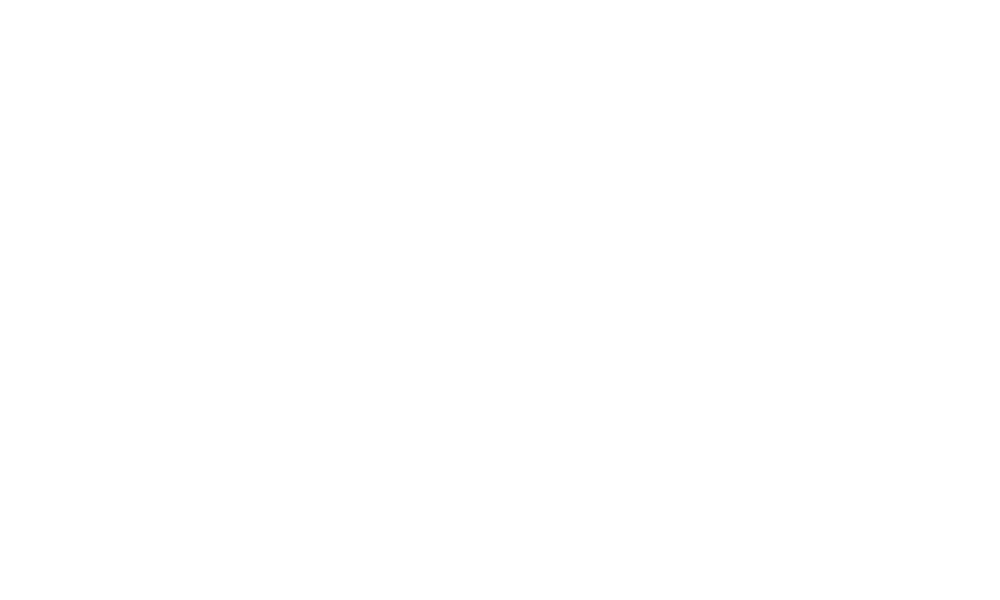

<IPython.core.display.Javascript object>


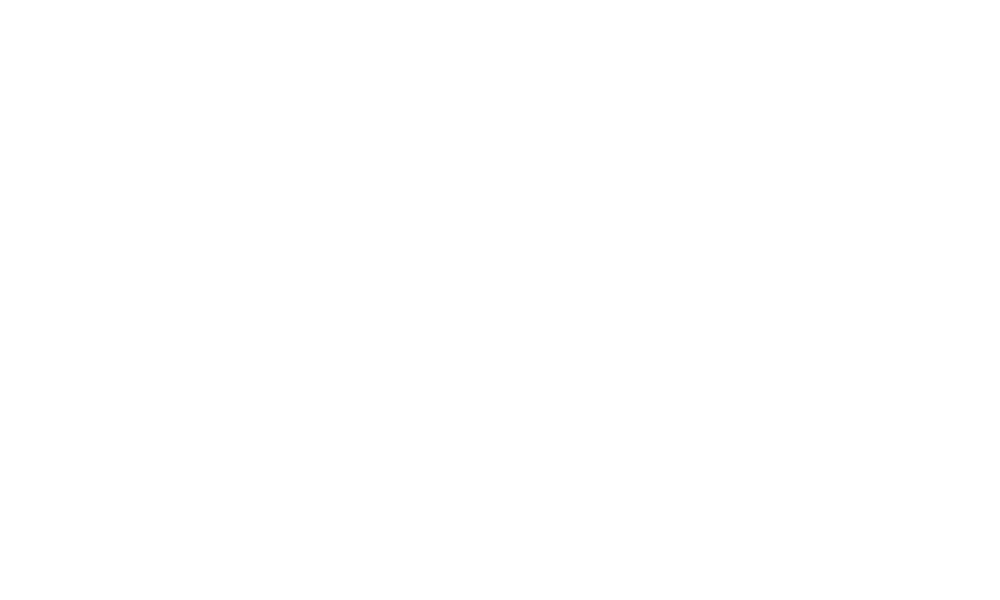

<IPython.core.display.Javascript object>


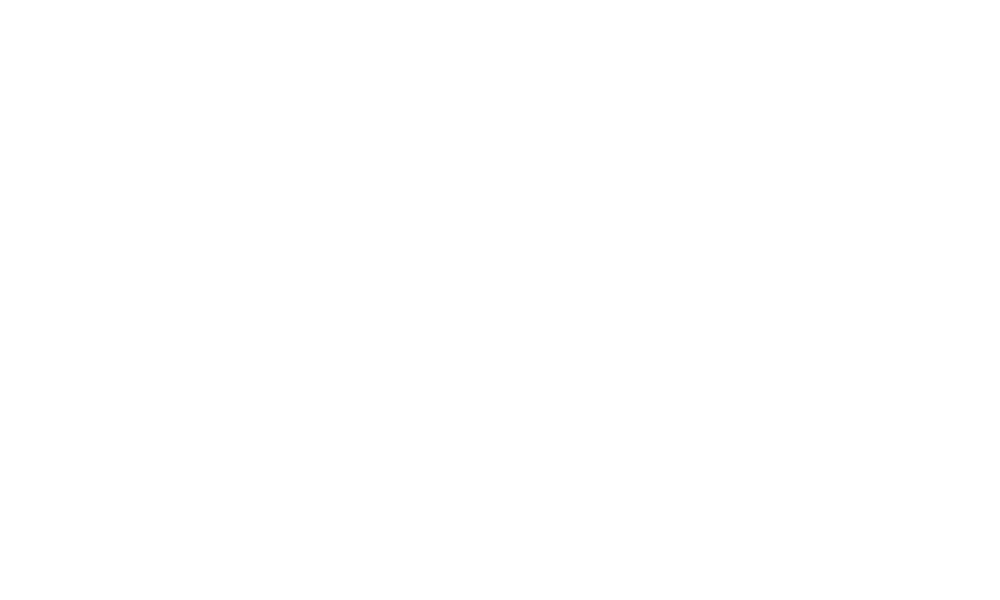

<IPython.core.display.Javascript object>


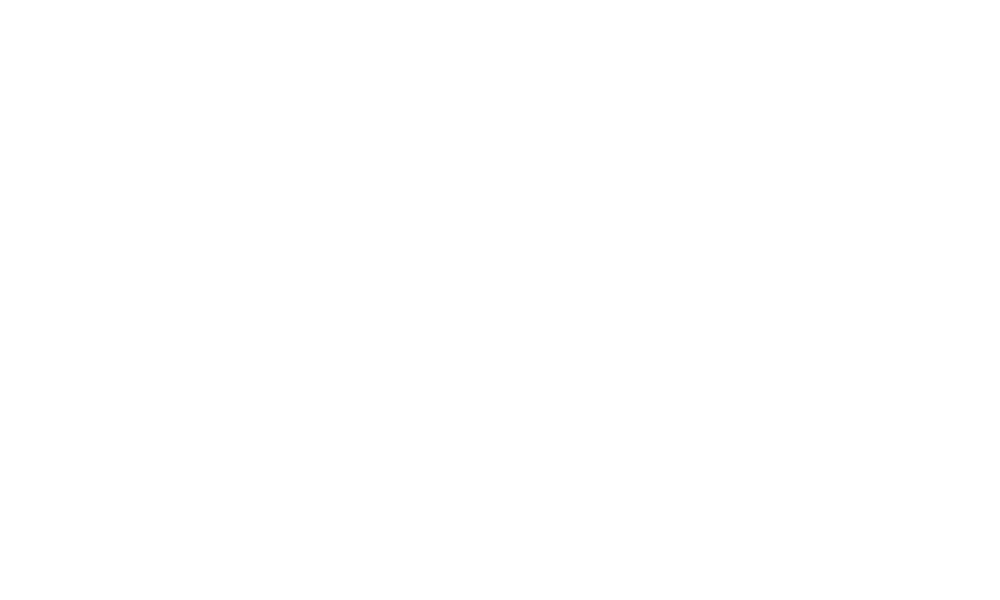

<IPython.core.display.Javascript object>


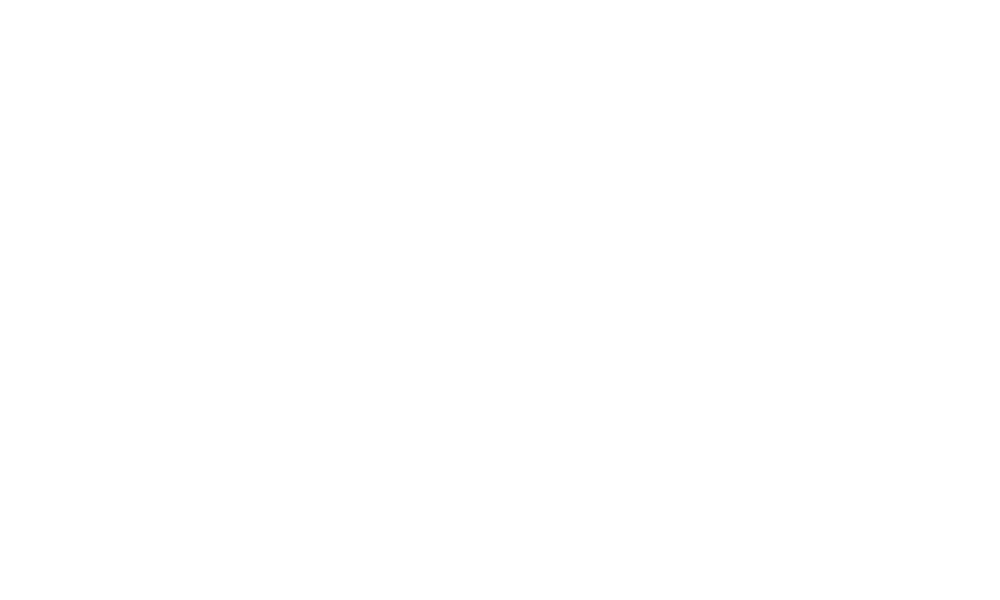

<IPython.core.display.Javascript object>


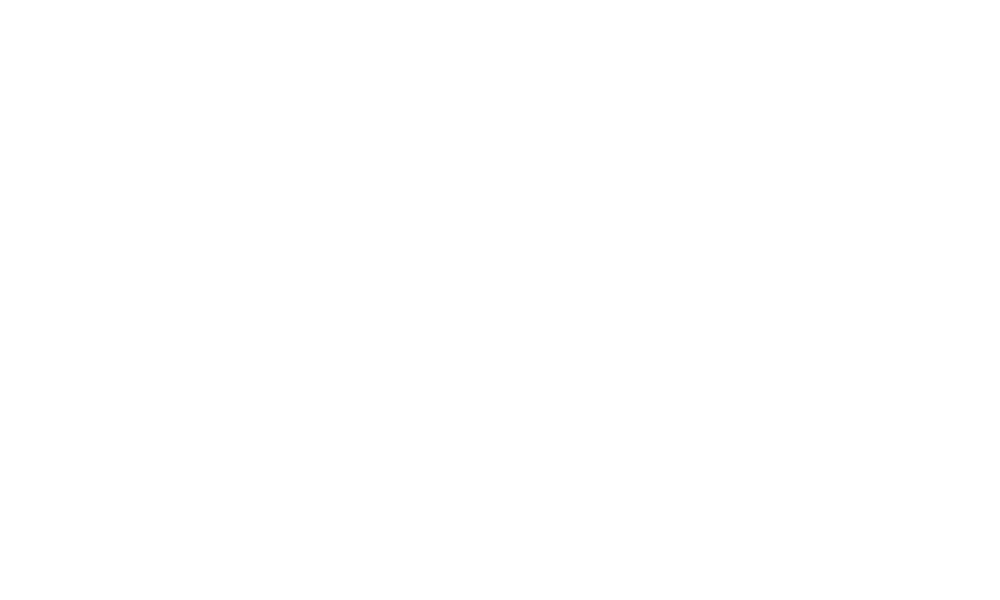

<IPython.core.display.Javascript object>


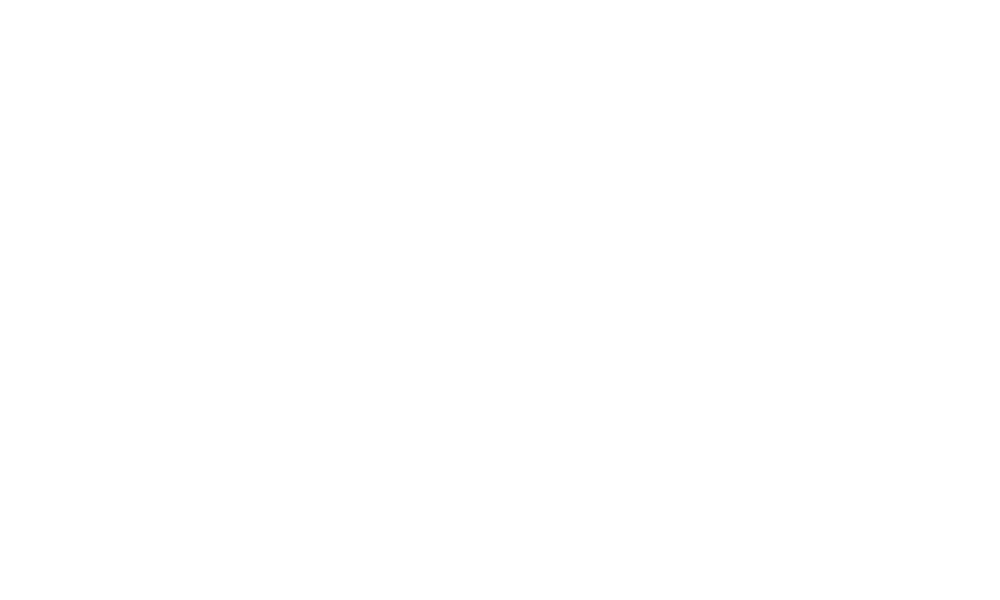

<IPython.core.display.Javascript object>


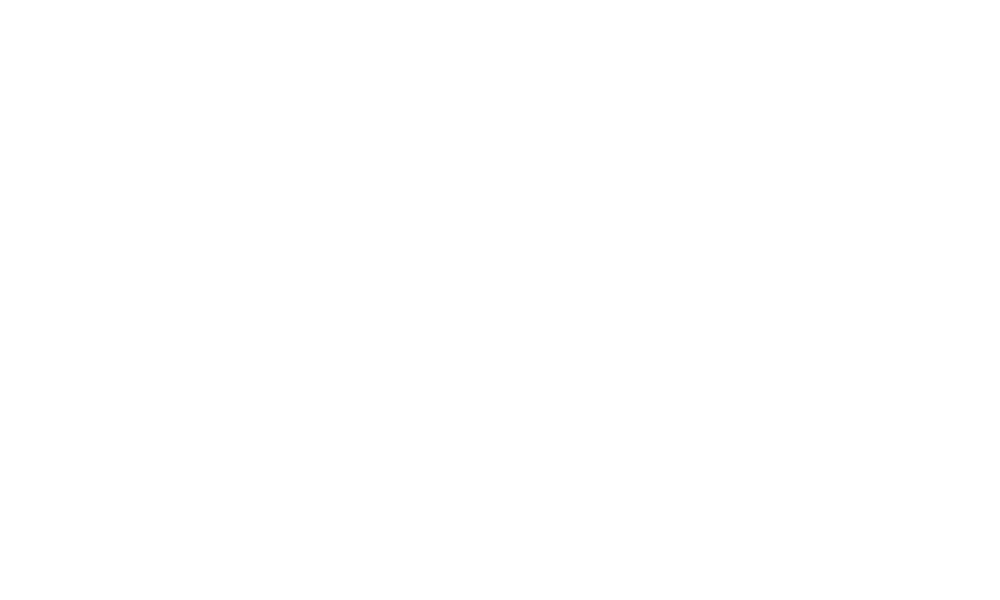

<IPython.core.display.Javascript object>


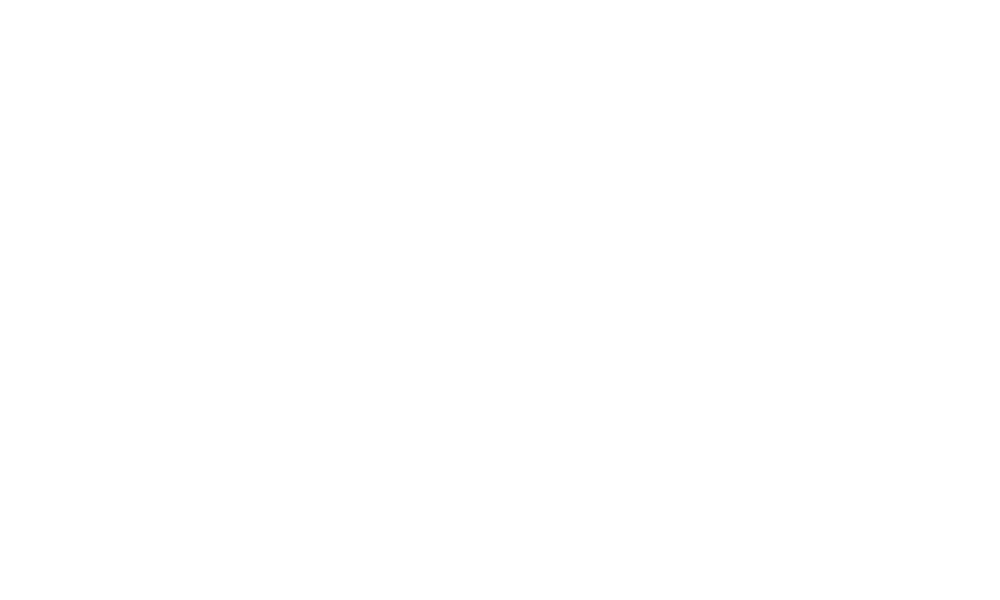

<IPython.core.display.Javascript object>


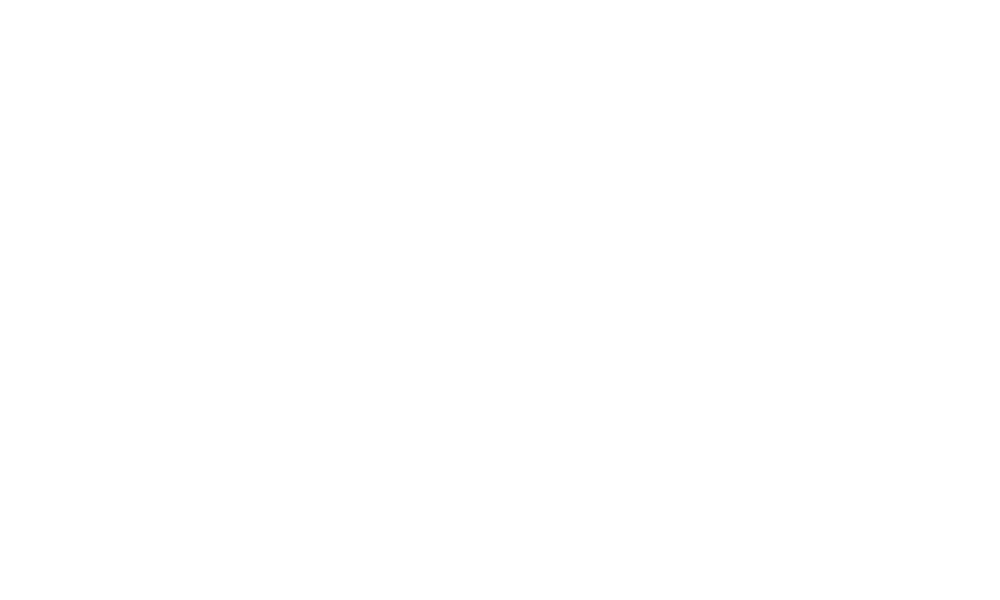

<IPython.core.display.Javascript object>


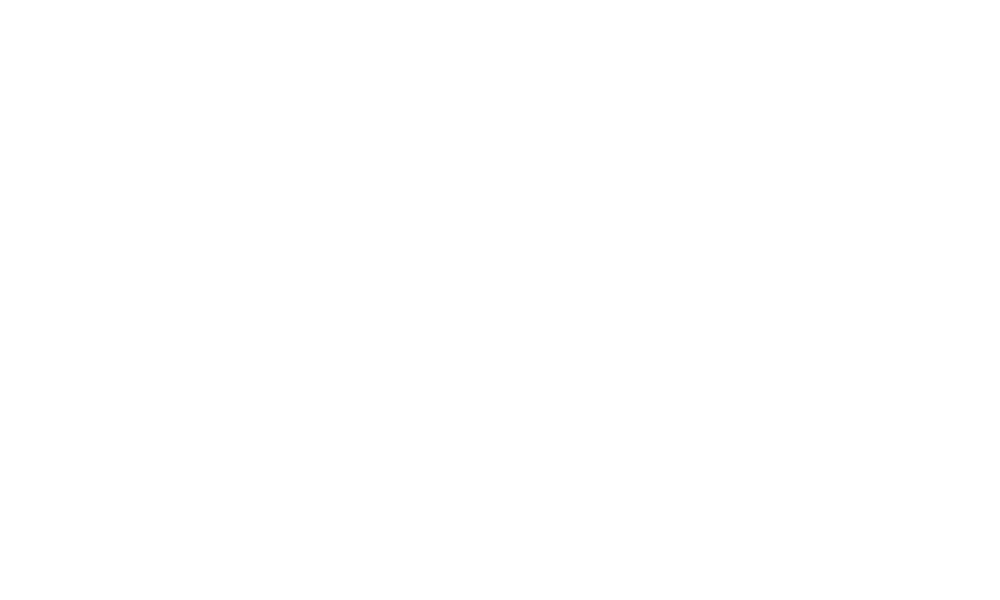

<IPython.core.display.Javascript object>


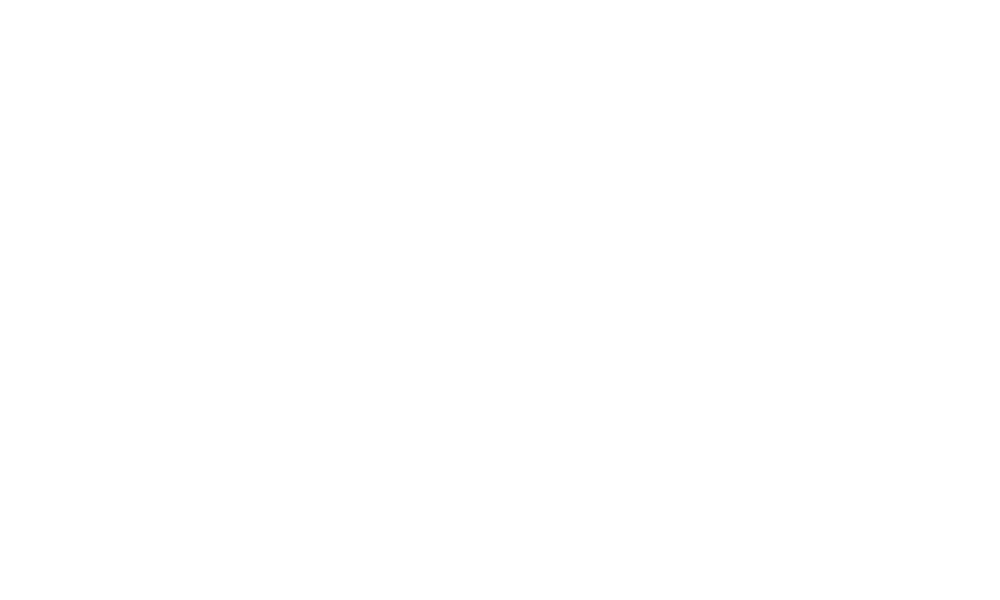

<IPython.core.display.Javascript object>


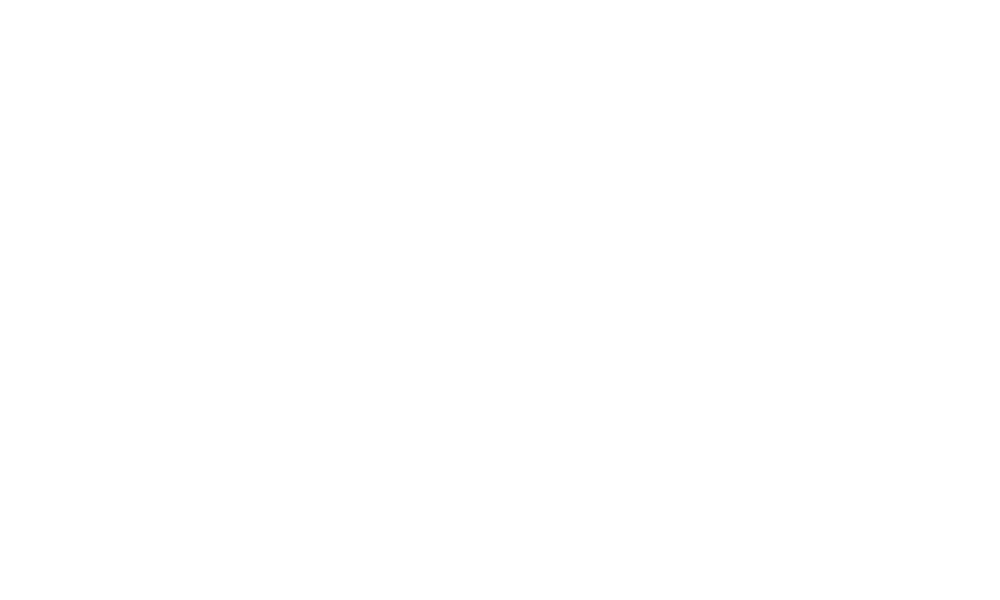

<IPython.core.display.Javascript object>


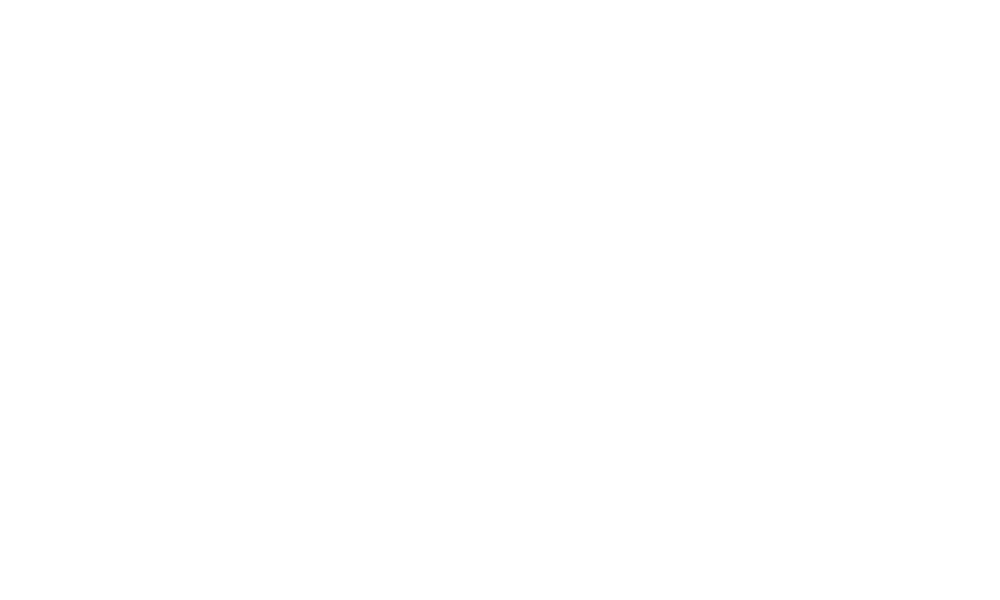

<IPython.core.display.Javascript object>


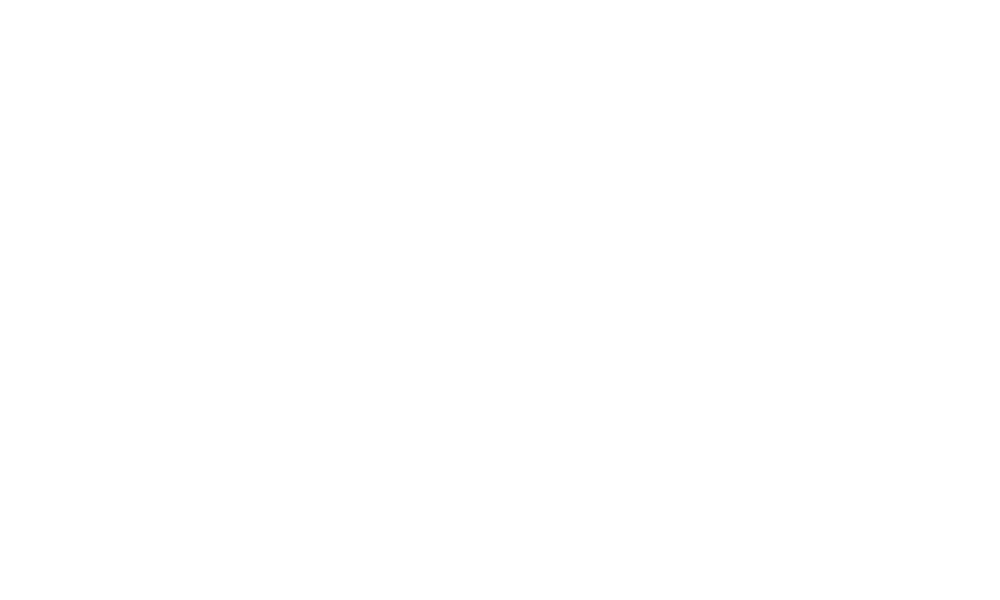

<IPython.core.display.Javascript object>


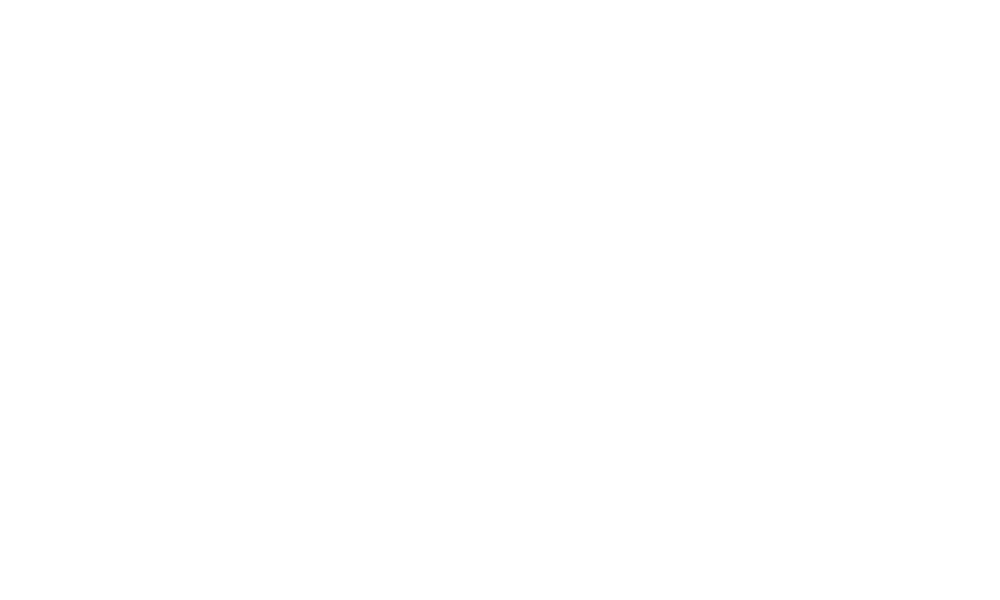

<IPython.core.display.Javascript object>


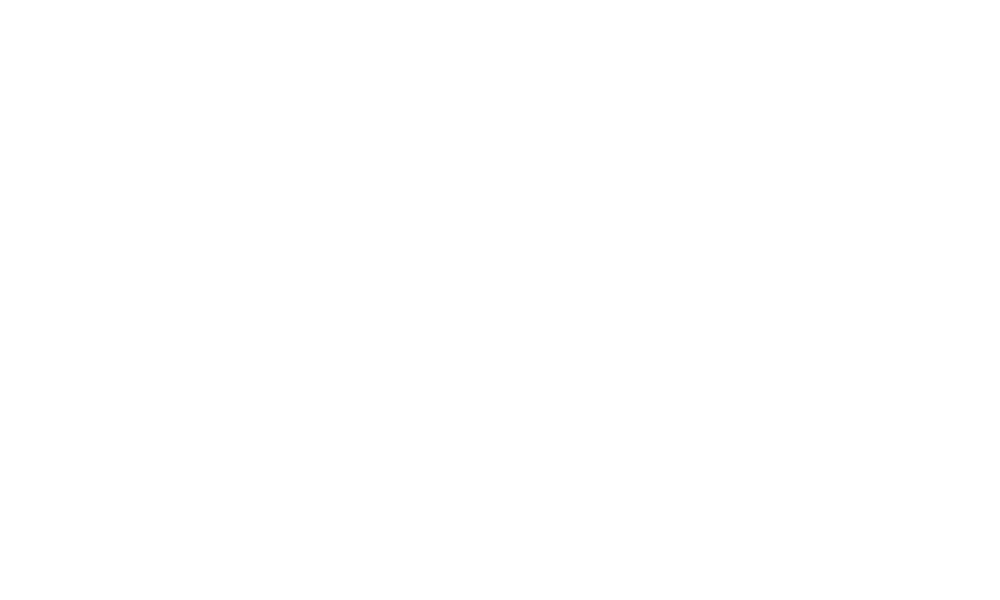

<IPython.core.display.Javascript object>


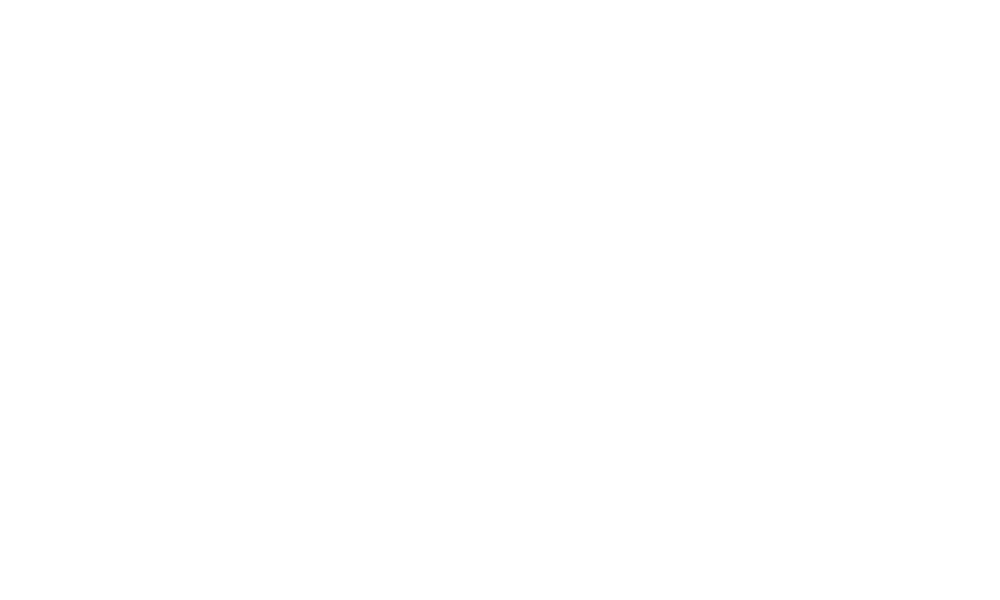

<IPython.core.display.Javascript object>


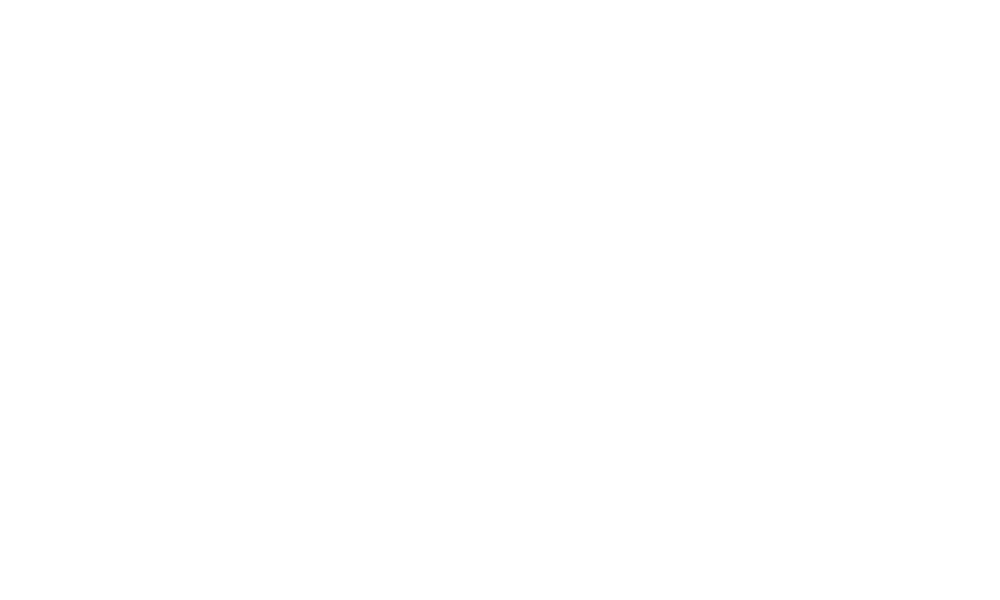

<IPython.core.display.Javascript object>


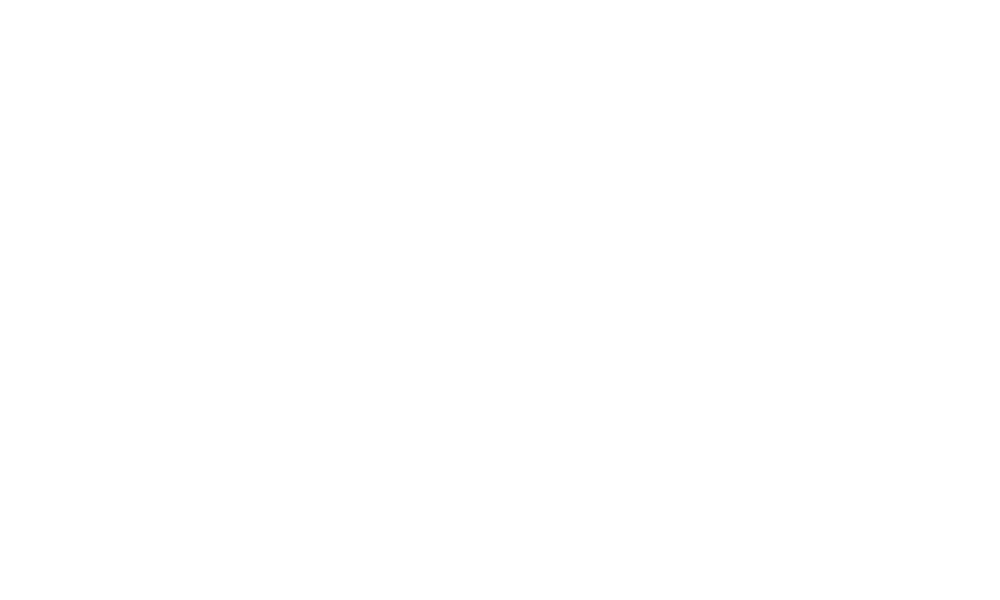

<IPython.core.display.Javascript object>


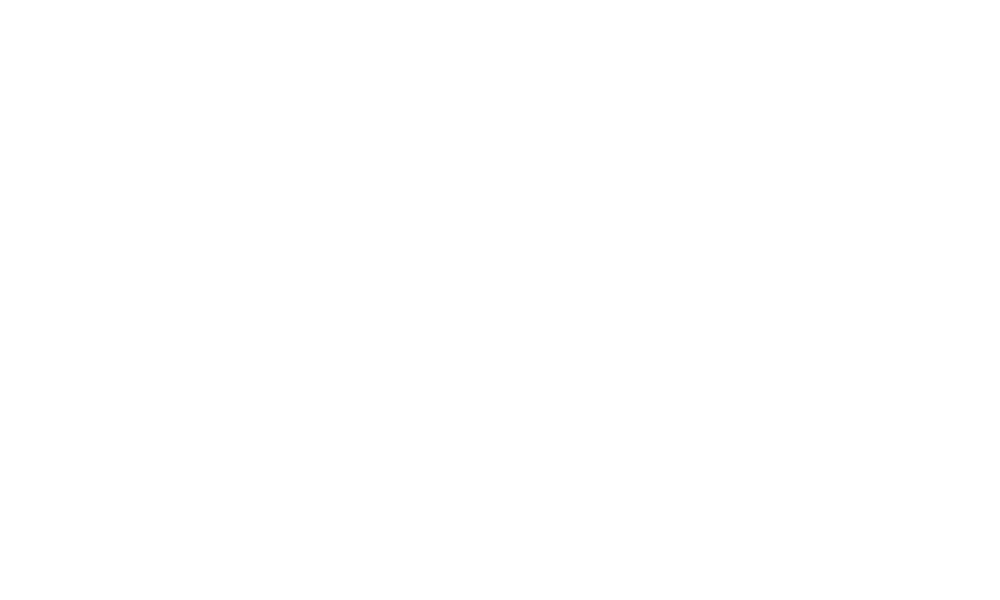

<IPython.core.display.Javascript object>


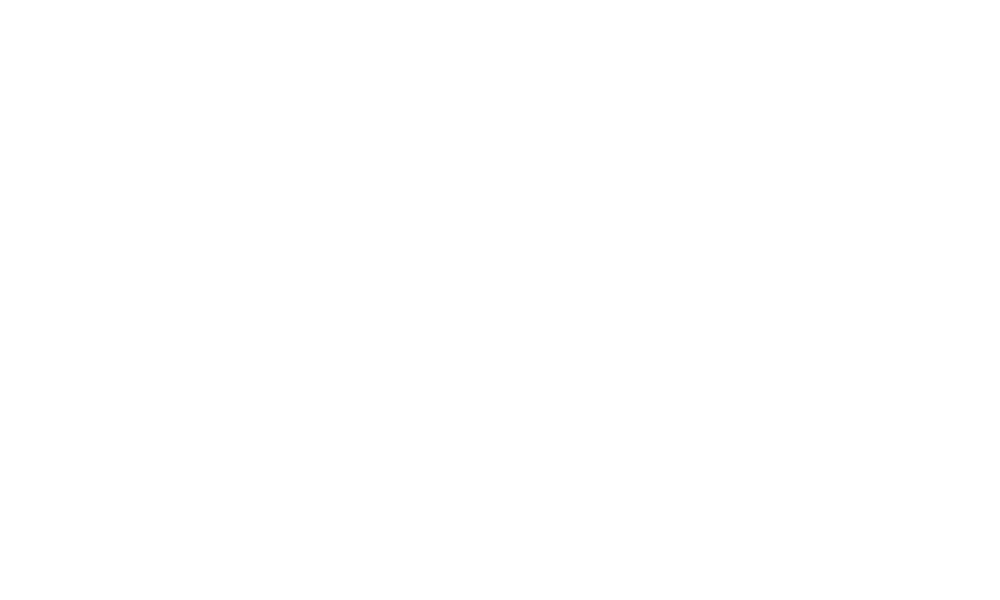

<IPython.core.display.Javascript object>


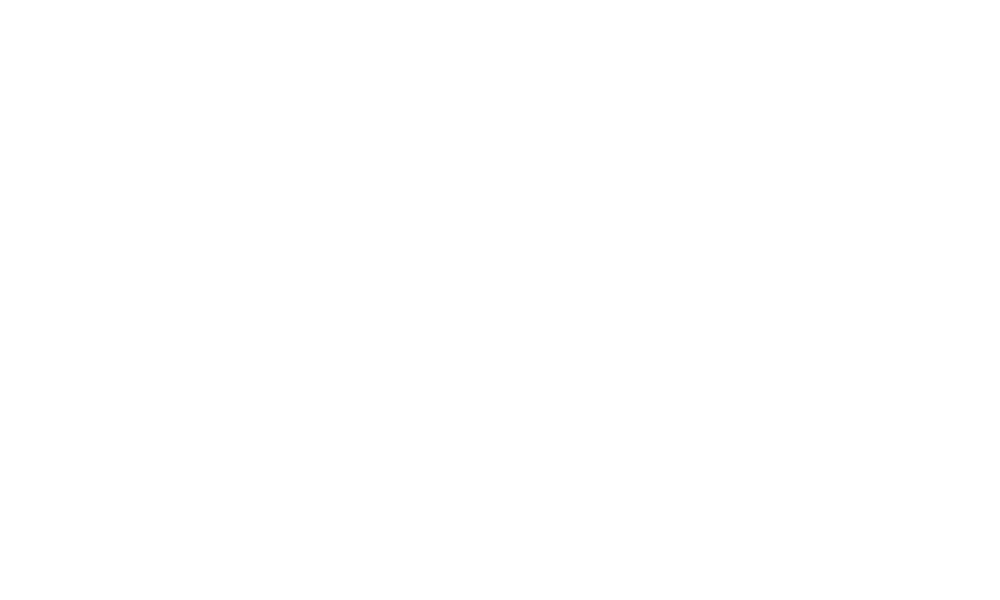

<IPython.core.display.Javascript object>


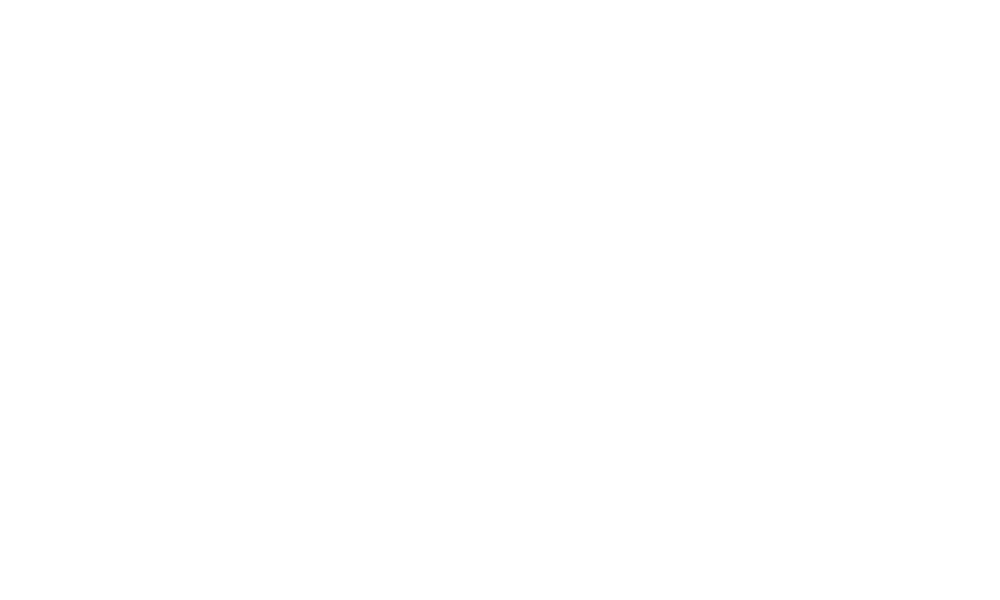

<IPython.core.display.Javascript object>


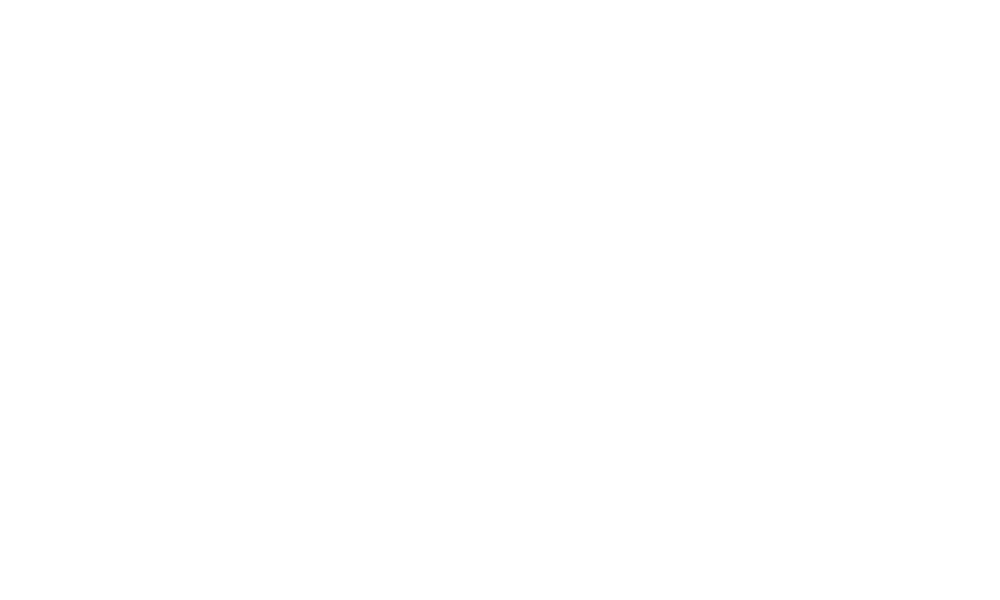

<IPython.core.display.Javascript object>


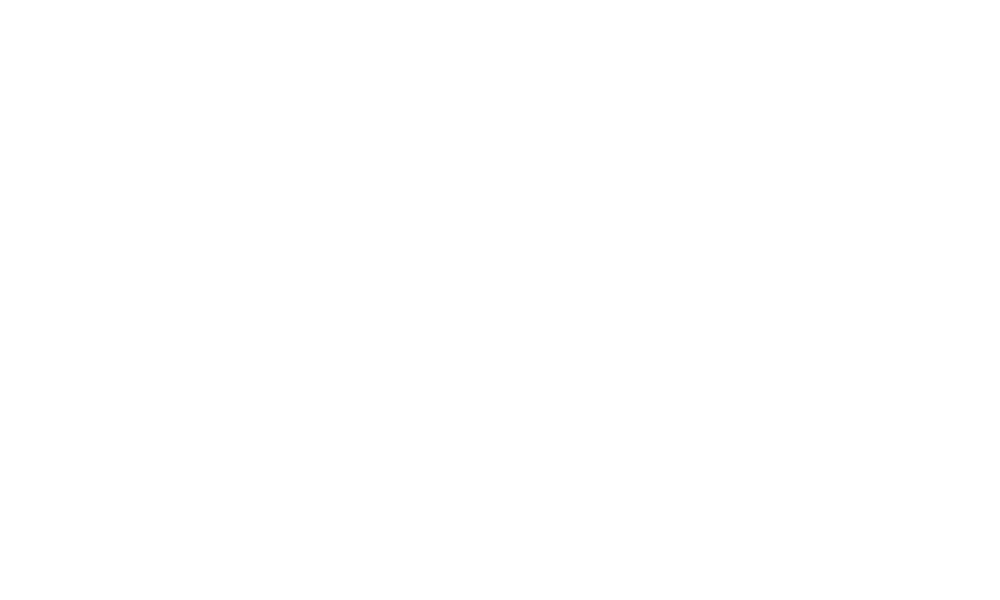

<IPython.core.display.Javascript object>


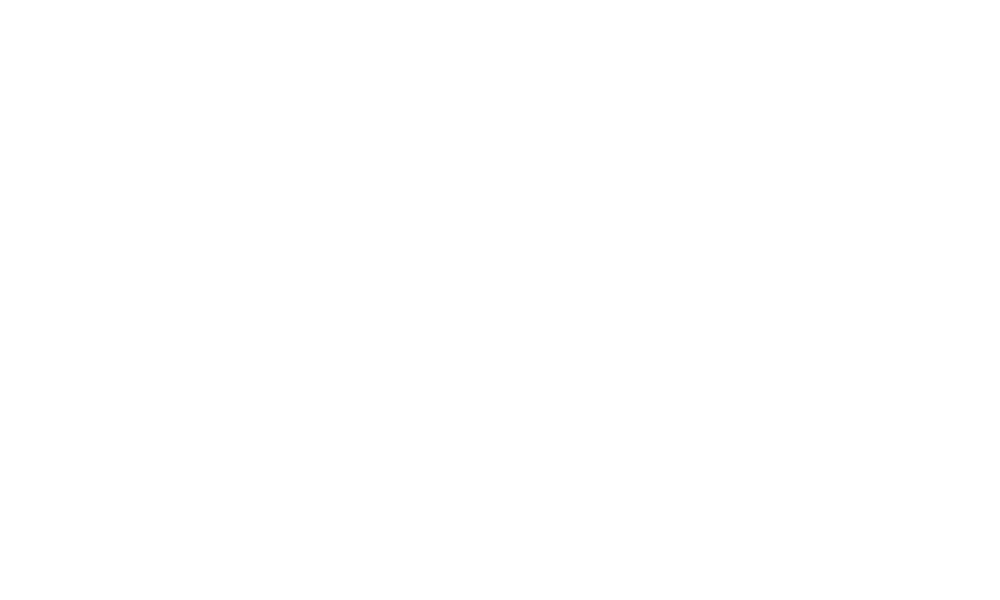

<IPython.core.display.Javascript object>


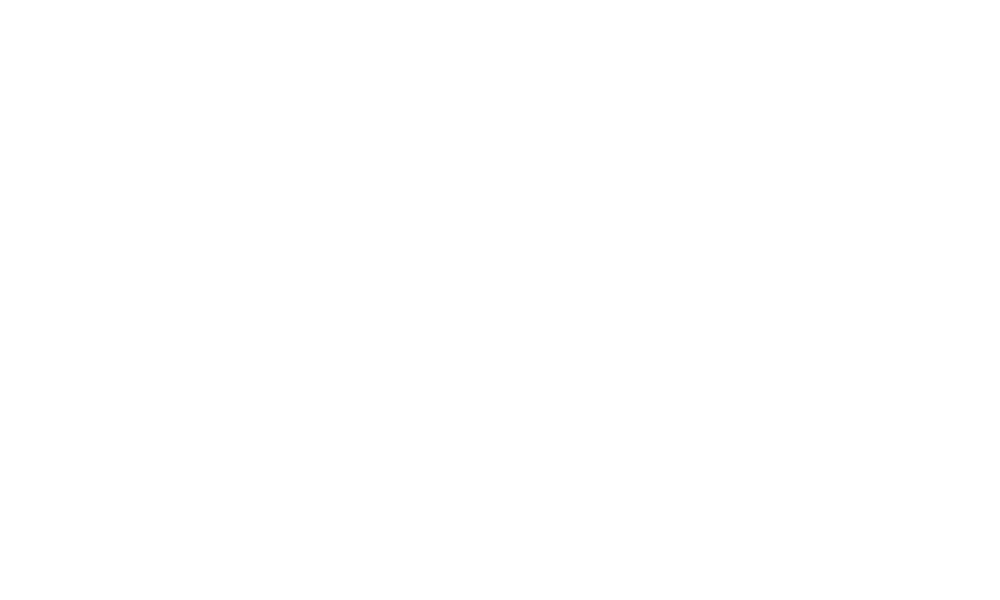

<IPython.core.display.Javascript object>


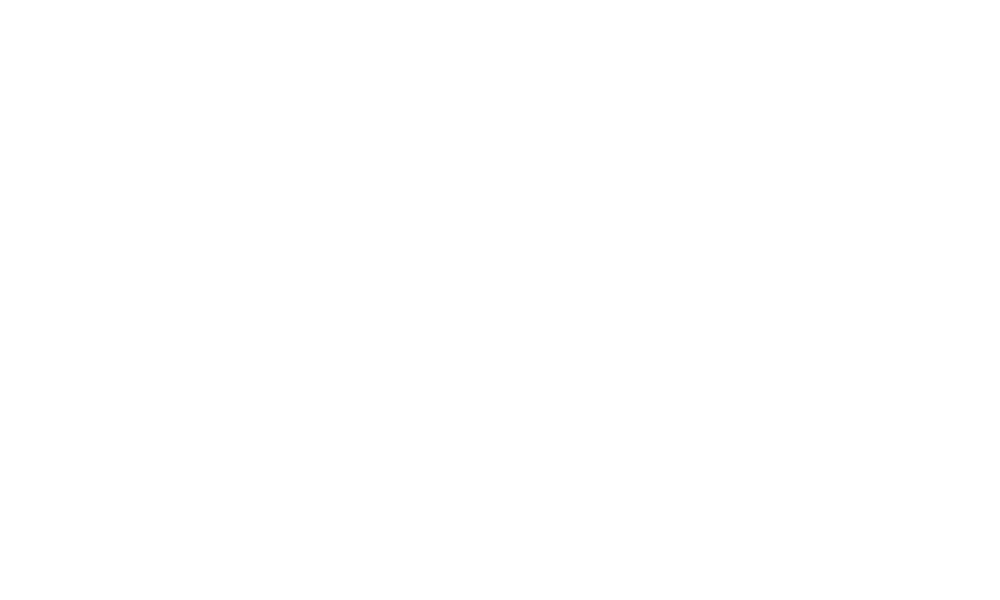

<IPython.core.display.Javascript object>


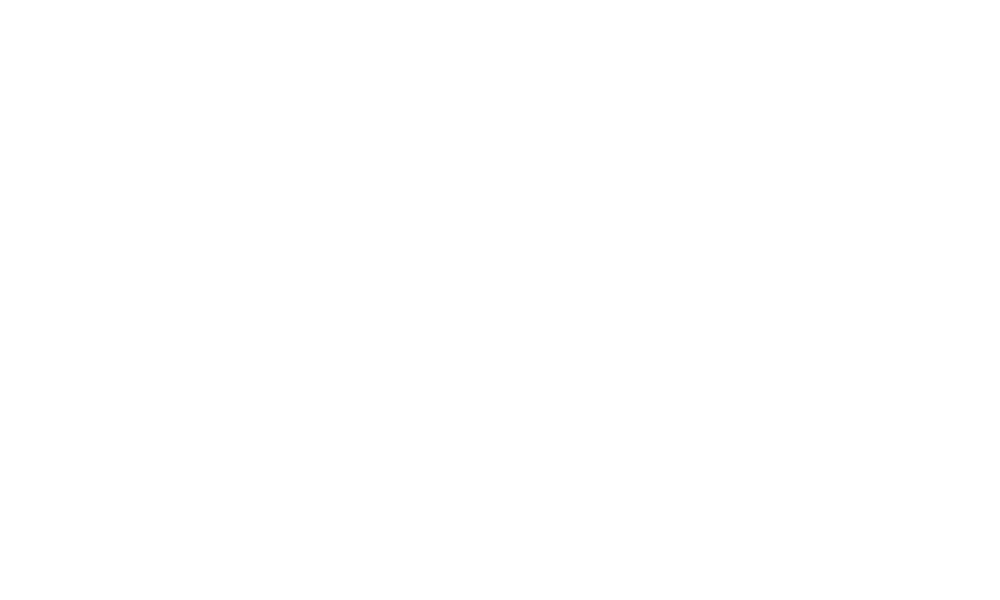

<IPython.core.display.Javascript object>


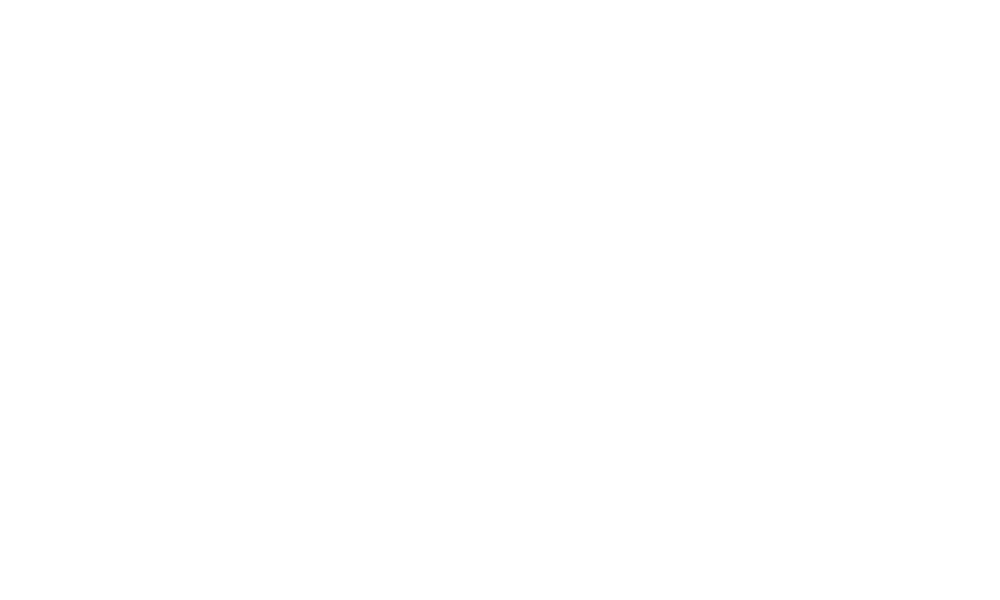

<IPython.core.display.Javascript object>


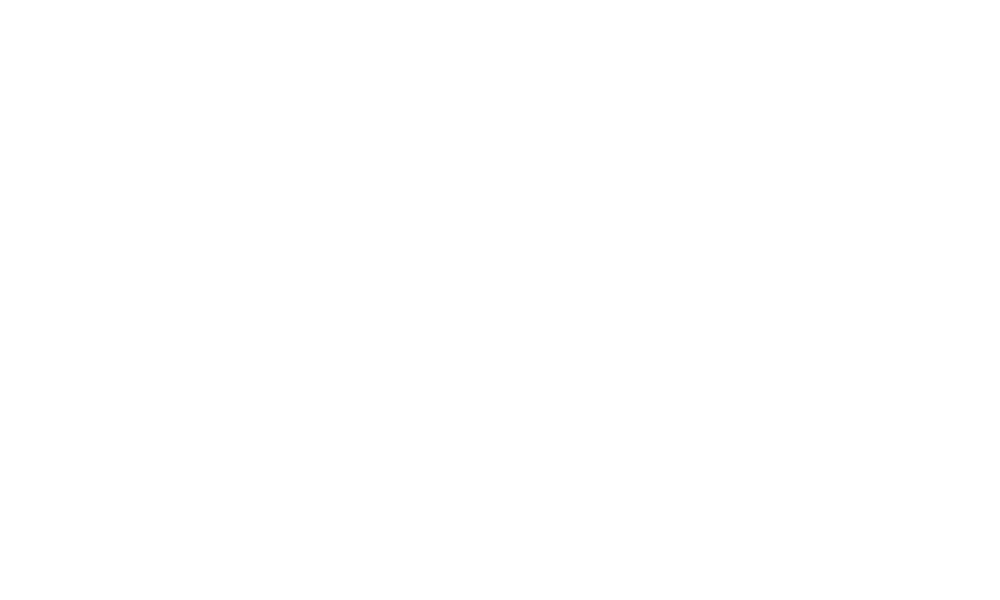

<IPython.core.display.Javascript object>


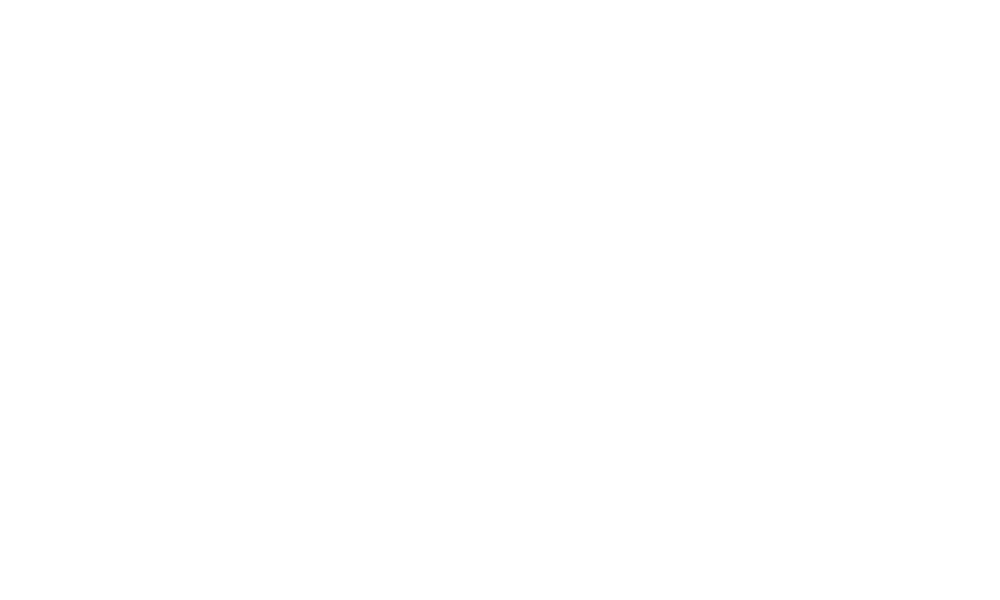

<IPython.core.display.Javascript object>


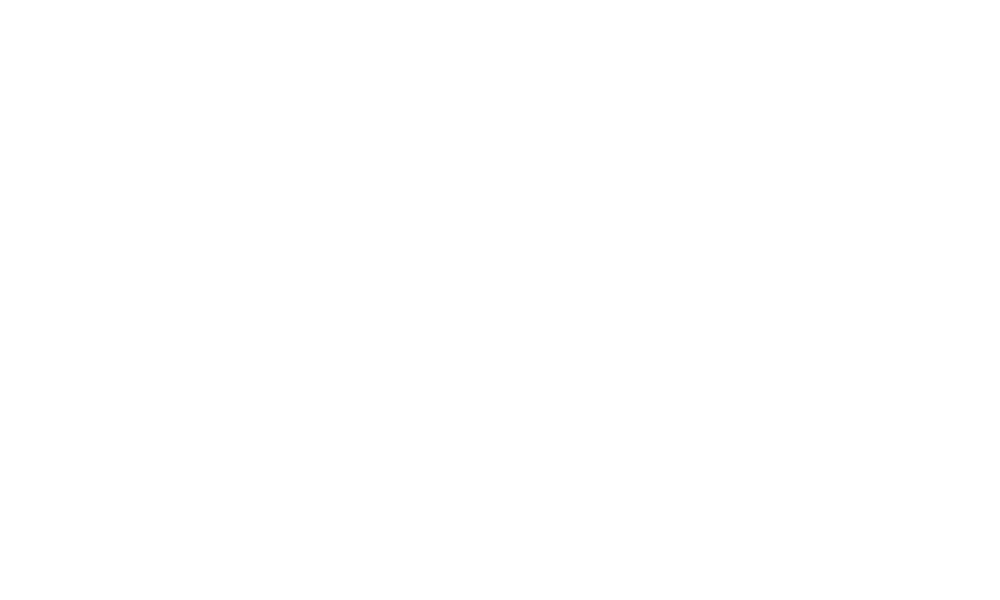

<IPython.core.display.Javascript object>


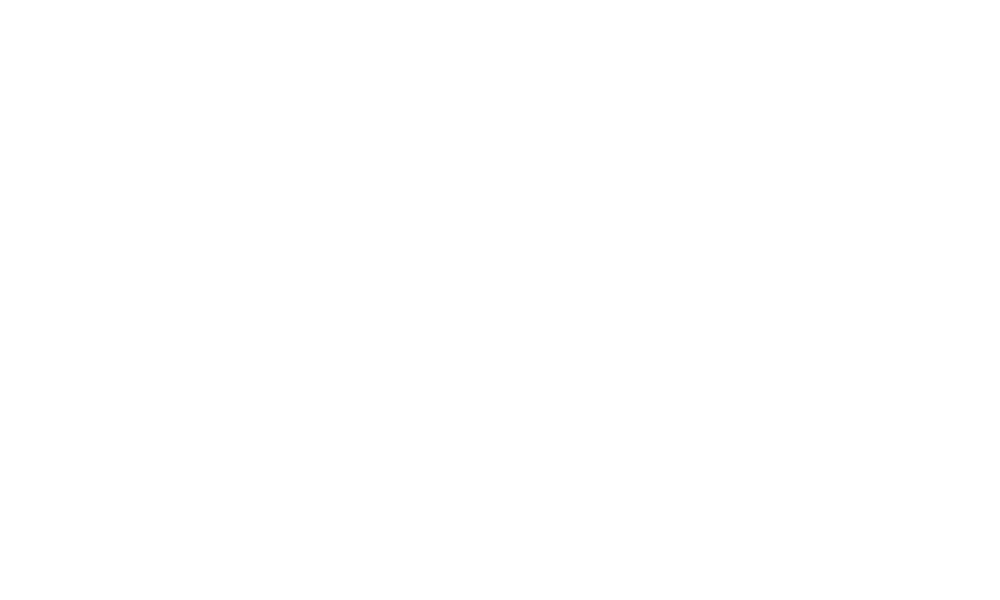

<IPython.core.display.Javascript object>


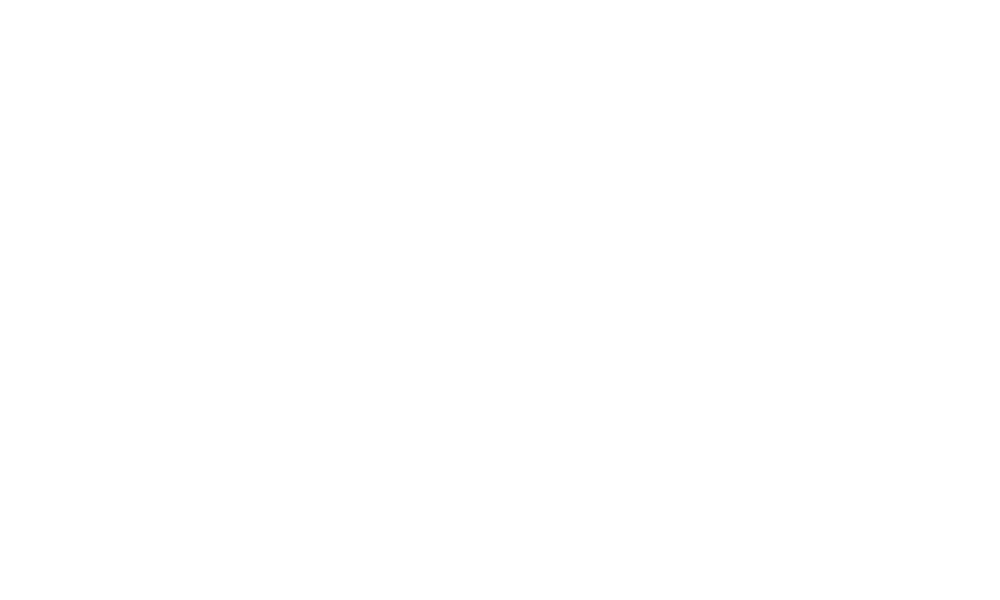

<IPython.core.display.Javascript object>


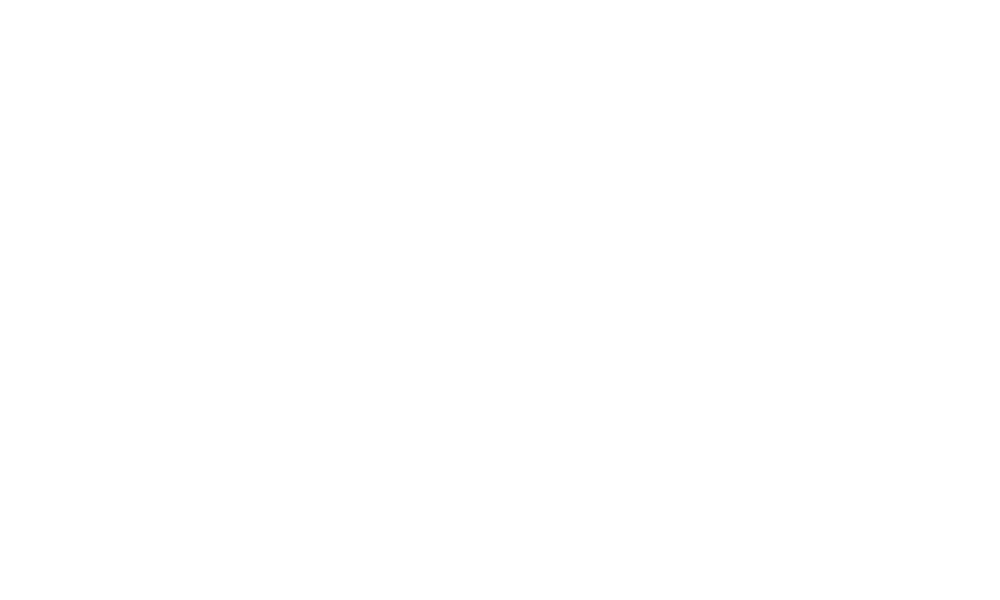

<IPython.core.display.Javascript object>


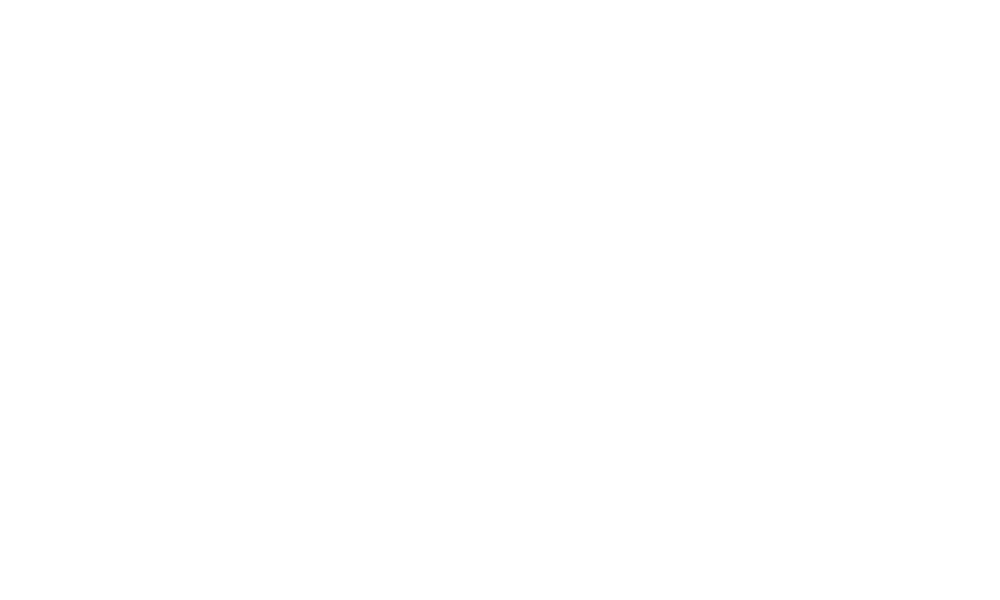

<IPython.core.display.Javascript object>


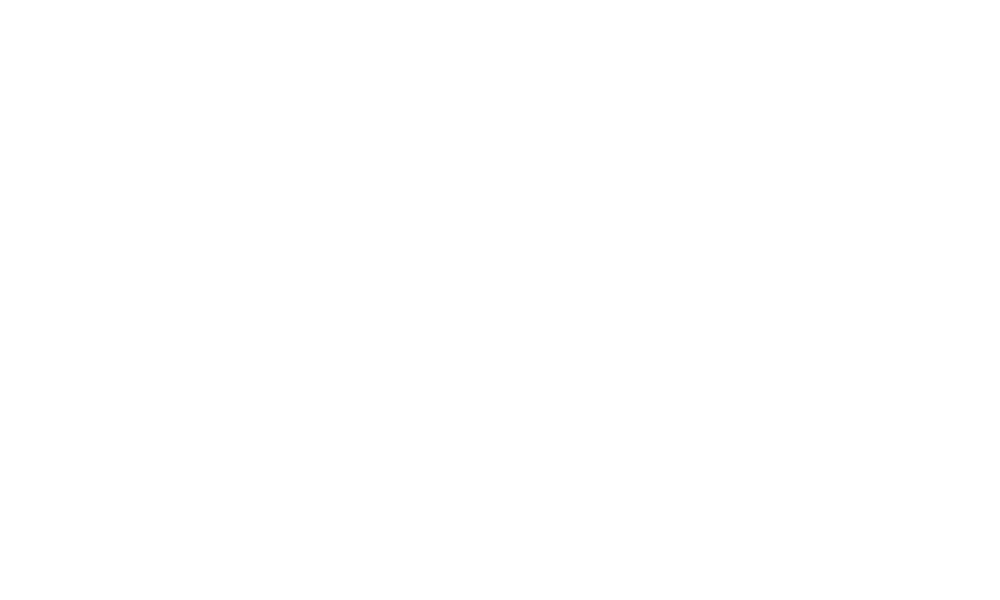

<IPython.core.display.Javascript object>


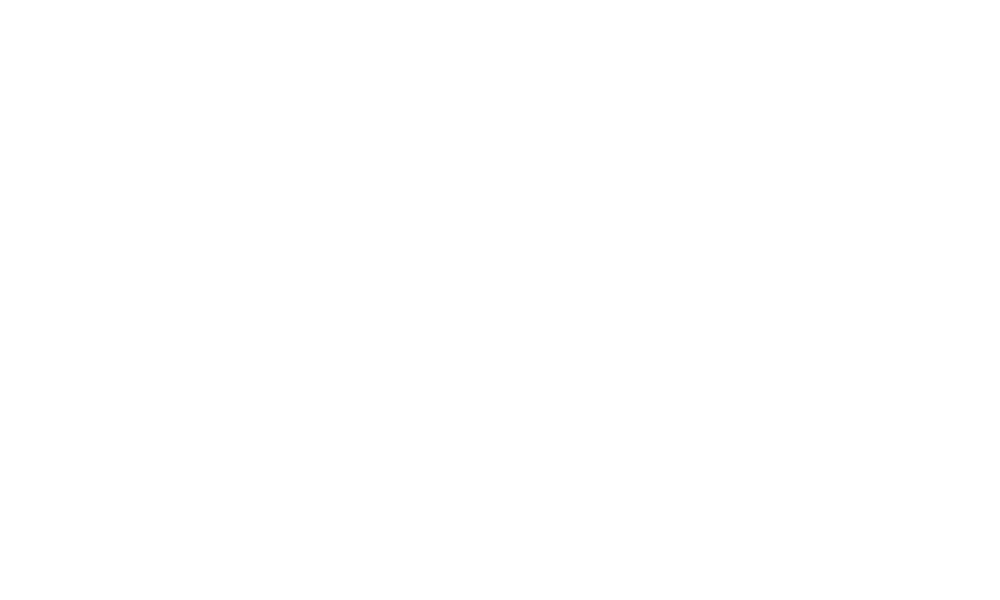

<IPython.core.display.Javascript object>


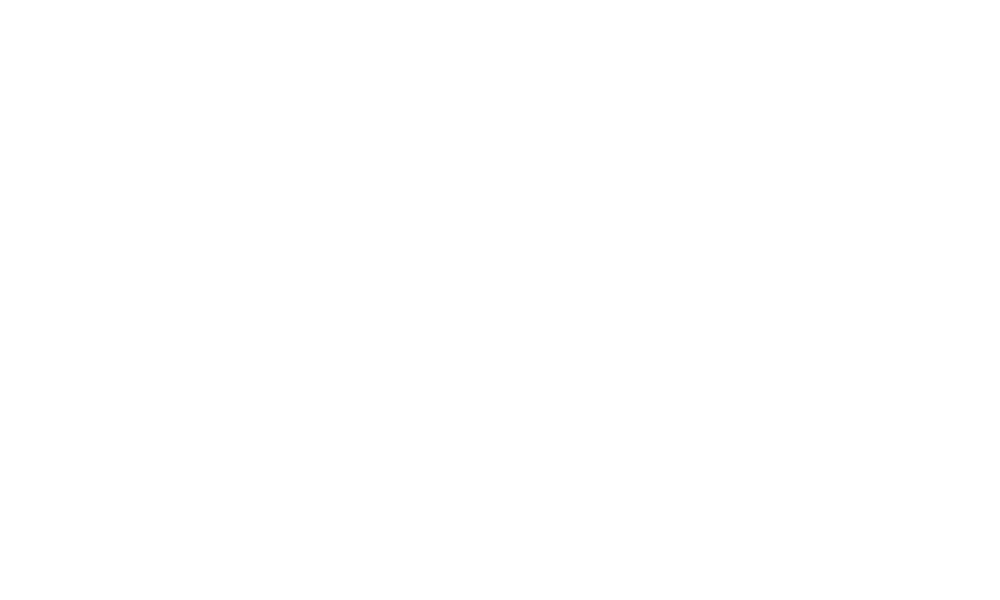

<IPython.core.display.Javascript object>


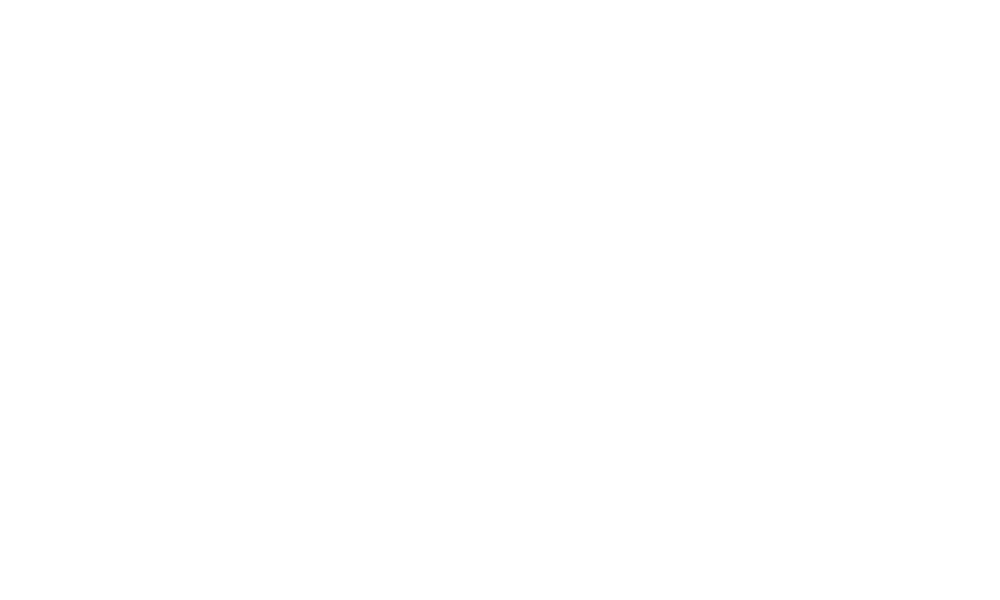

<IPython.core.display.Javascript object>


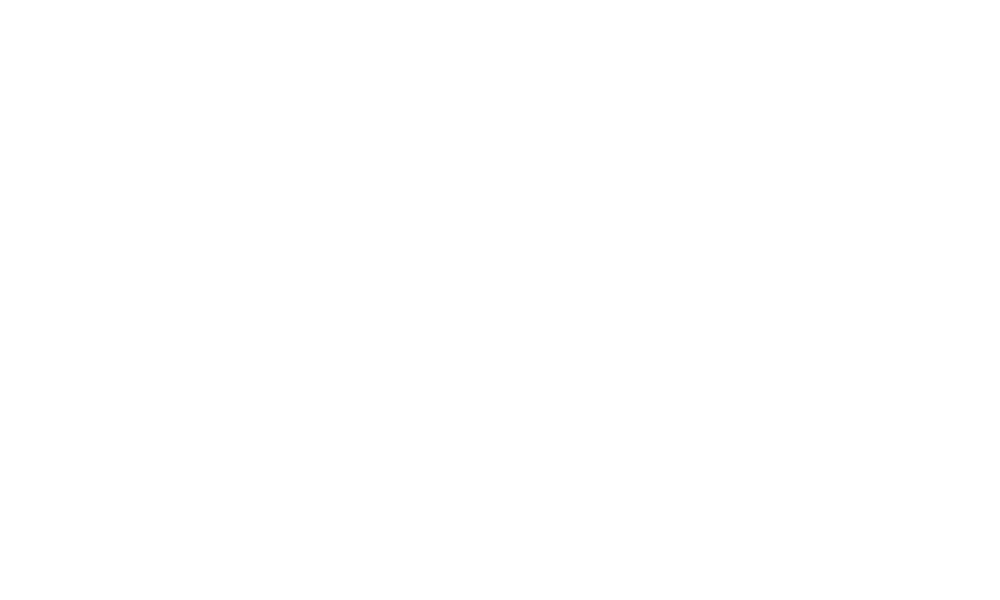

<IPython.core.display.Javascript object>


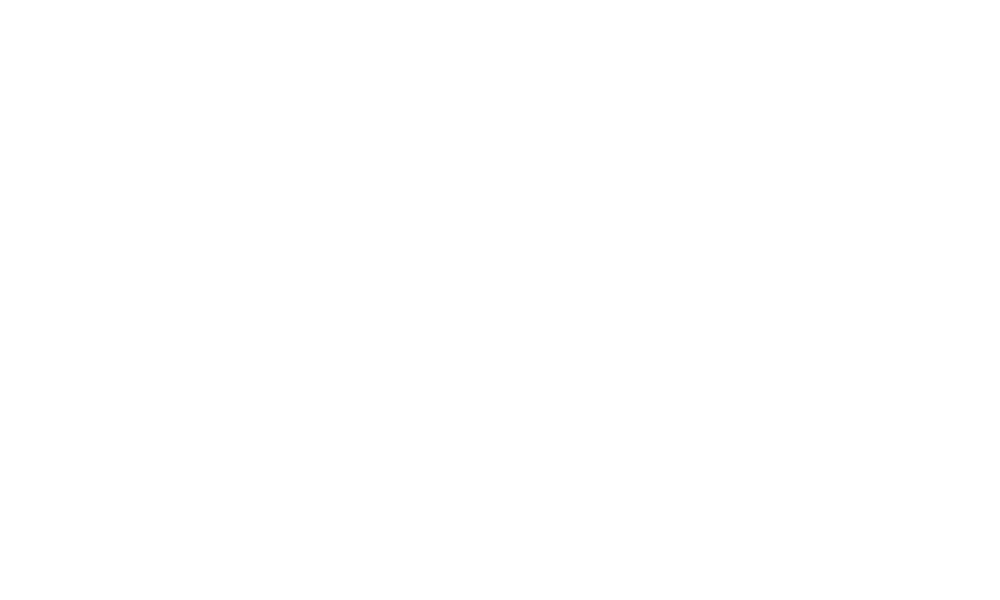

<IPython.core.display.Javascript object>


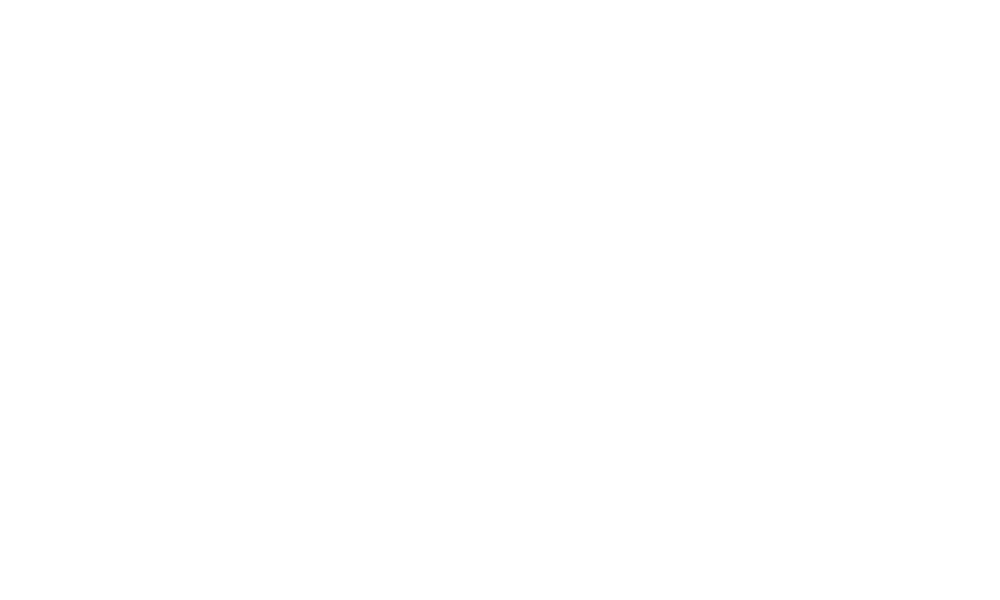

<IPython.core.display.Javascript object>


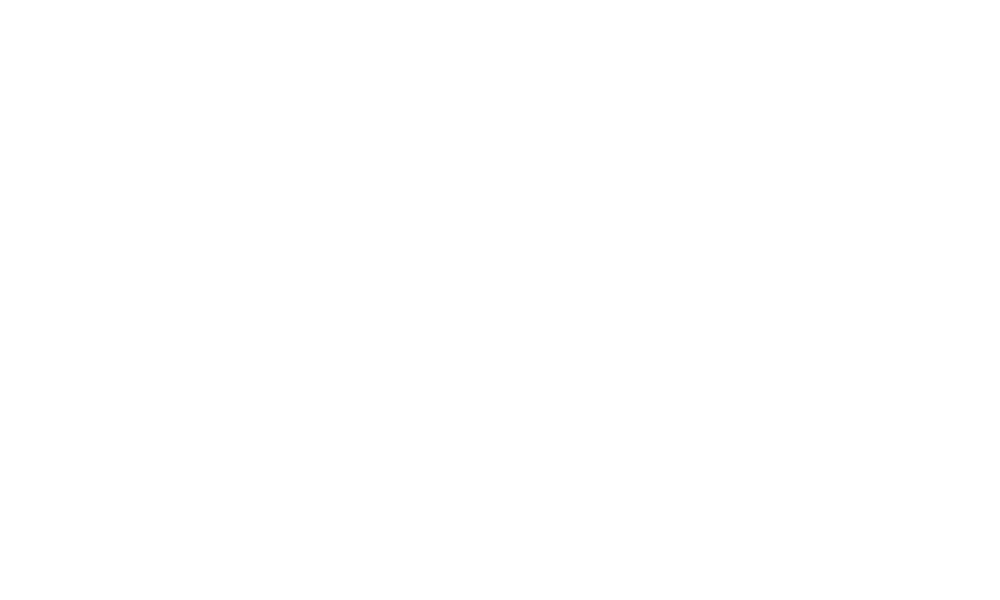

<IPython.core.display.Javascript object>


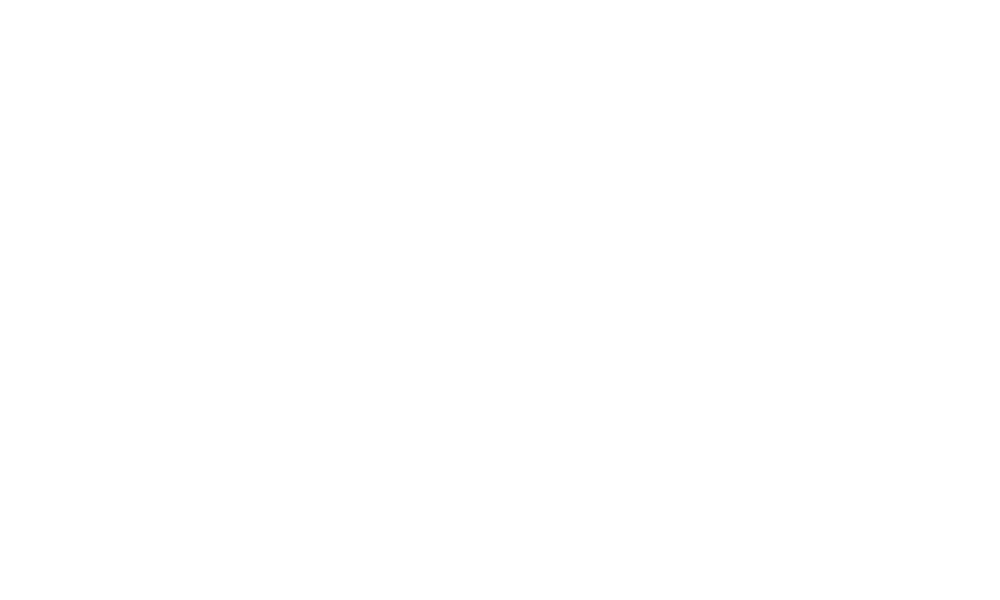

<IPython.core.display.Javascript object>


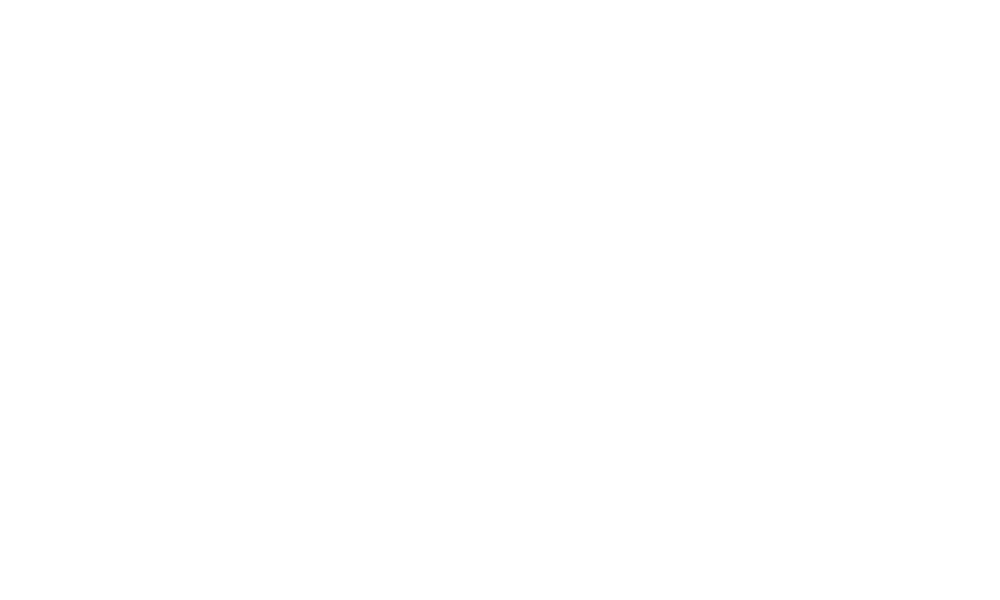

<IPython.core.display.Javascript object>


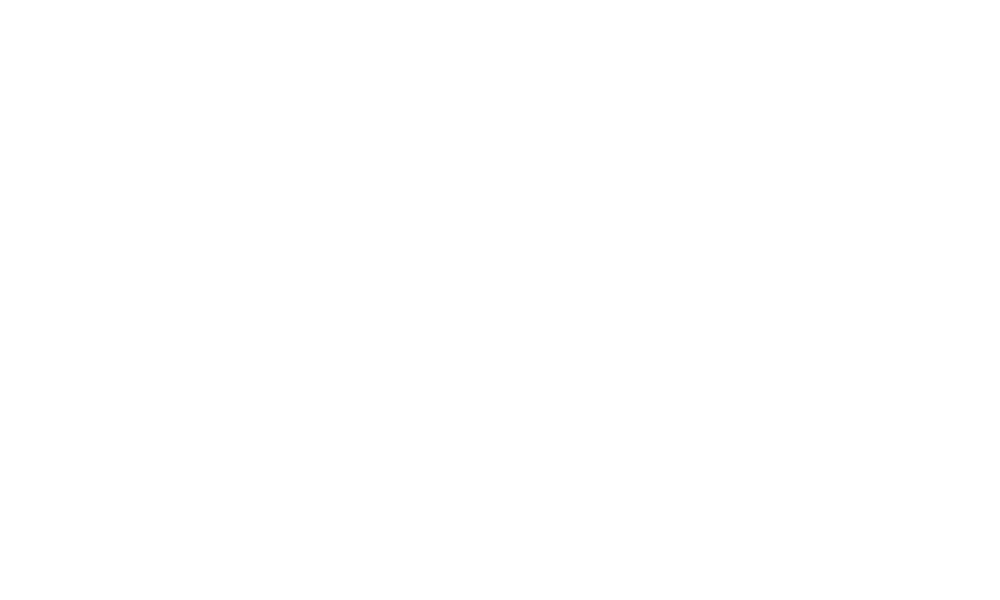

<IPython.core.display.Javascript object>


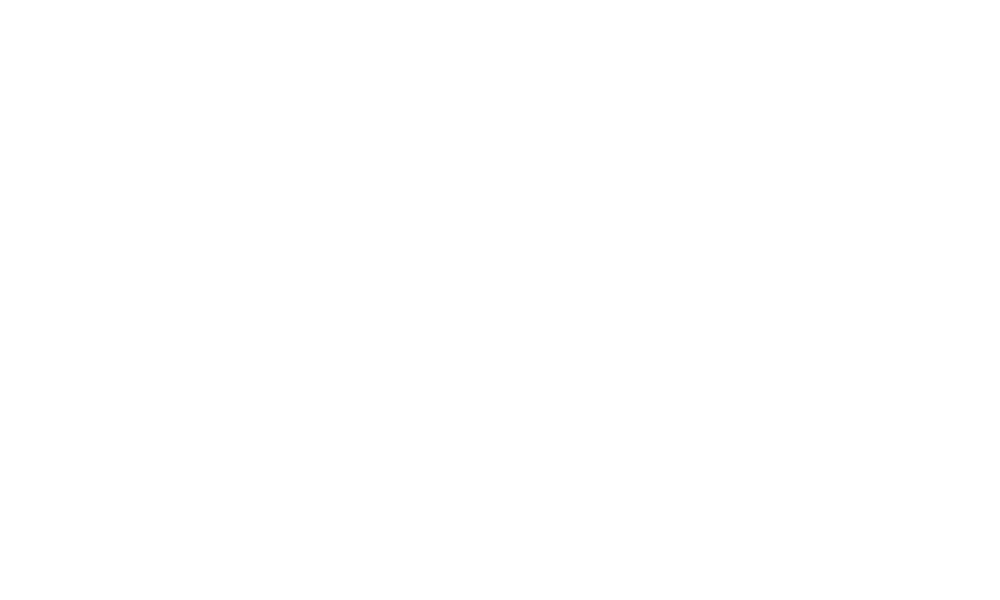

<IPython.core.display.Javascript object>


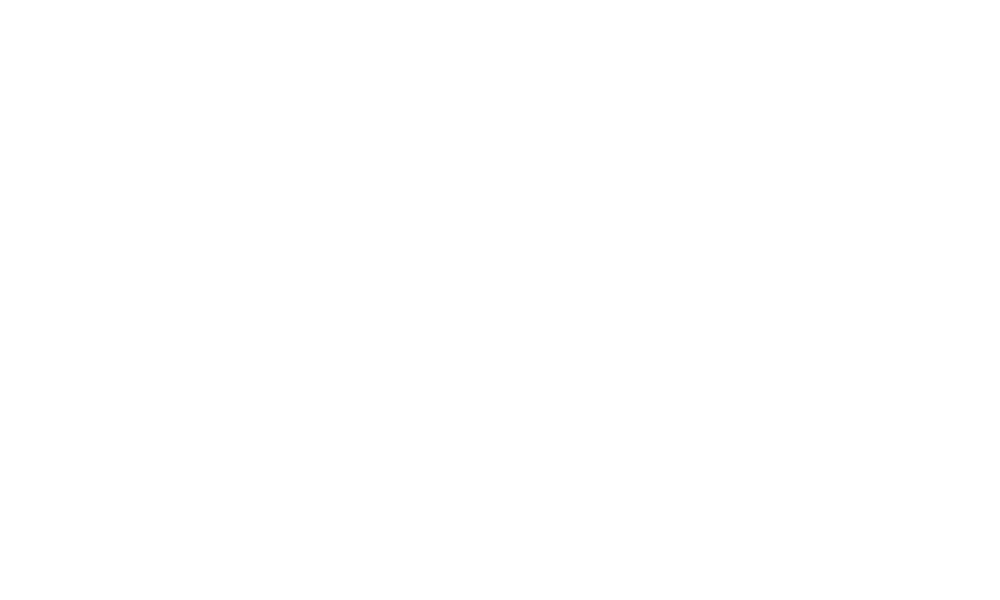

<IPython.core.display.Javascript object>


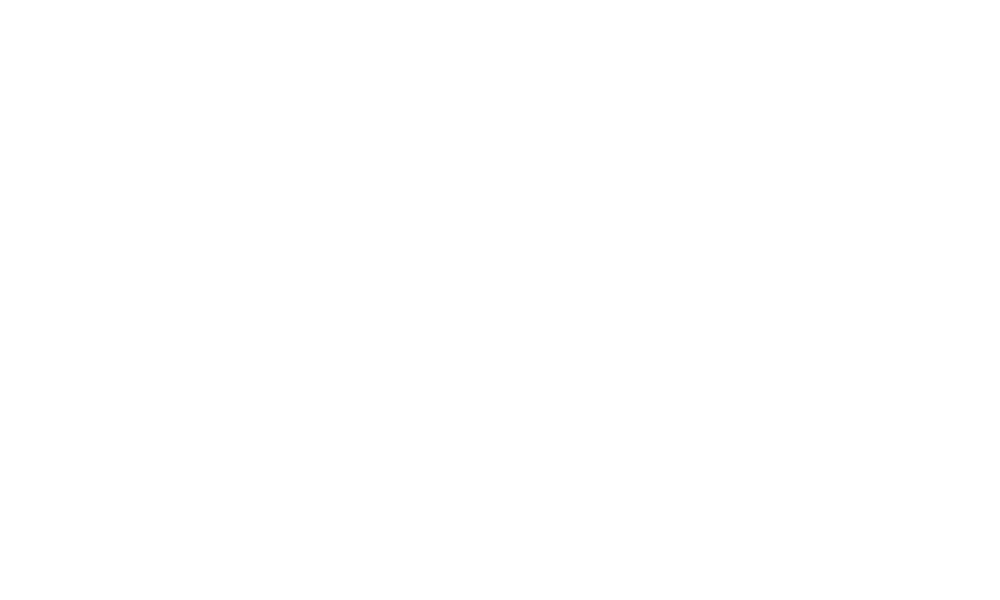

<IPython.core.display.Javascript object>


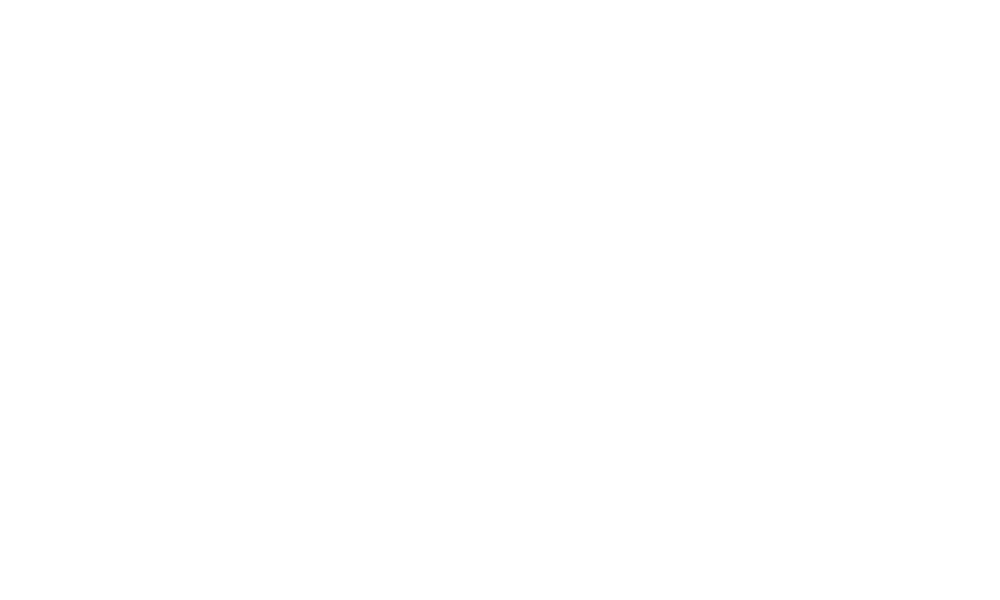

<IPython.core.display.Javascript object>


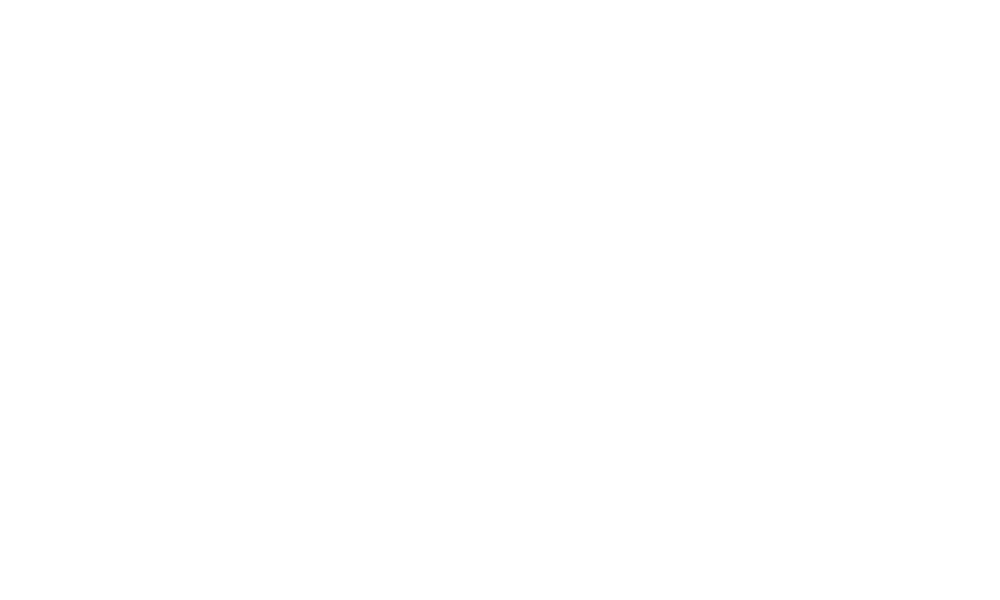

<IPython.core.display.Javascript object>


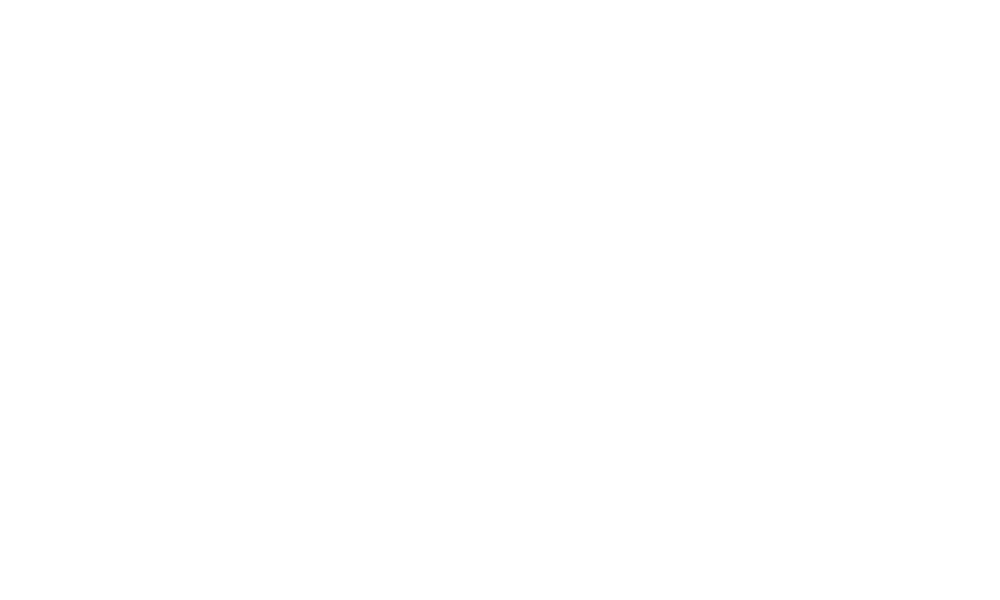

<IPython.core.display.Javascript object>


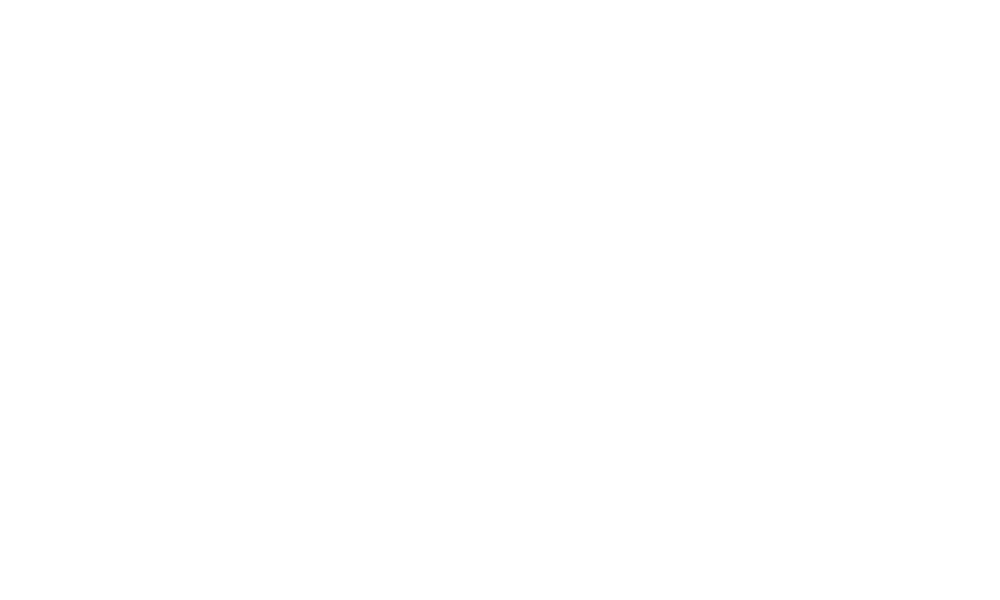

<IPython.core.display.Javascript object>


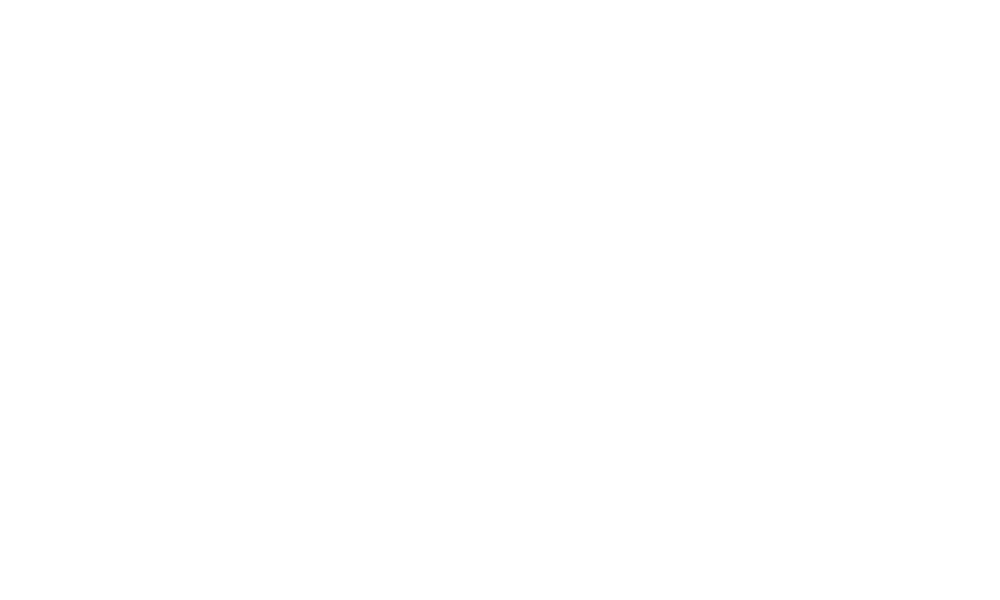

<IPython.core.display.Javascript object>


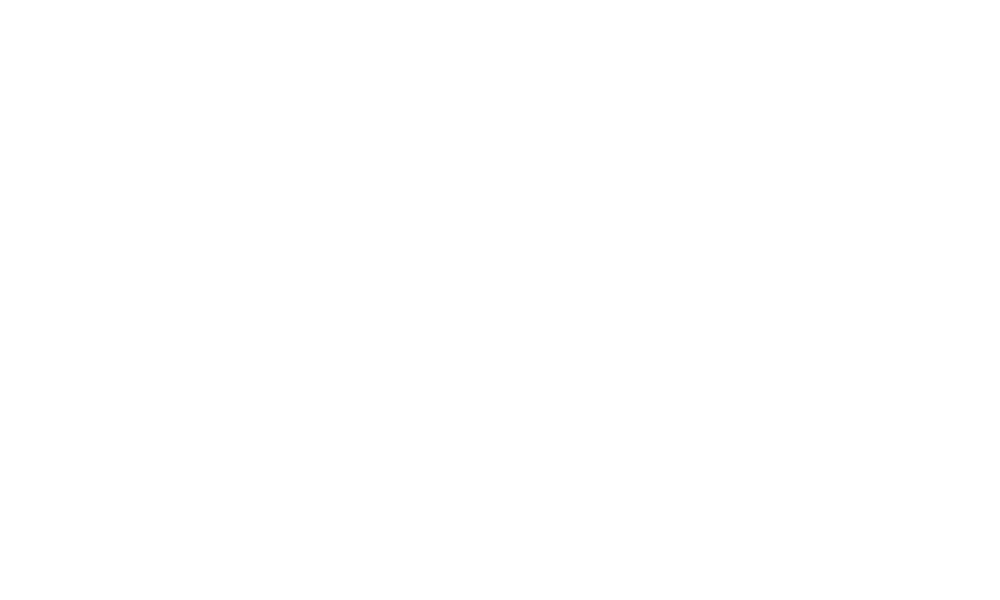

<IPython.core.display.Javascript object>


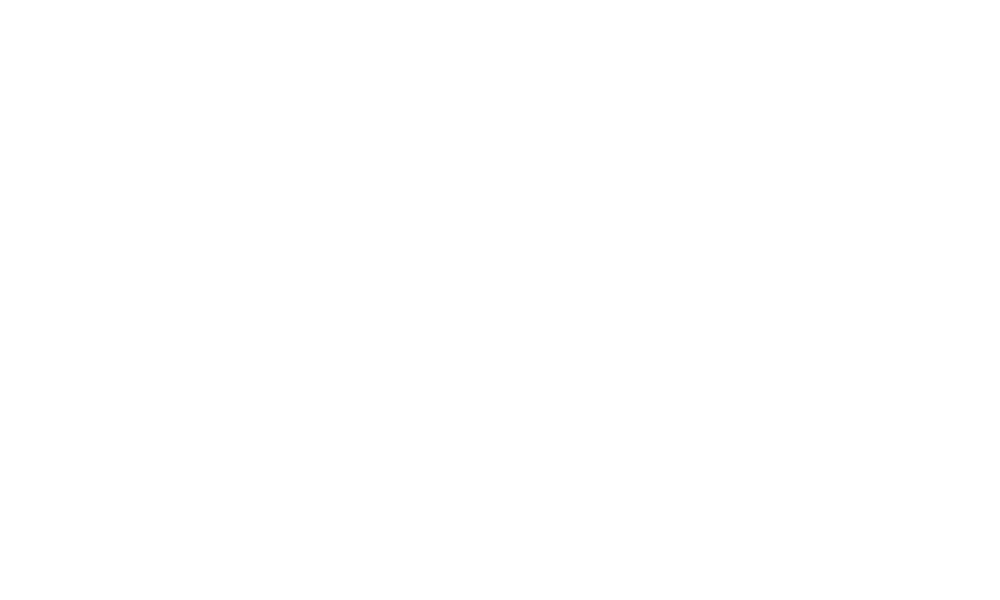

<IPython.core.display.Javascript object>


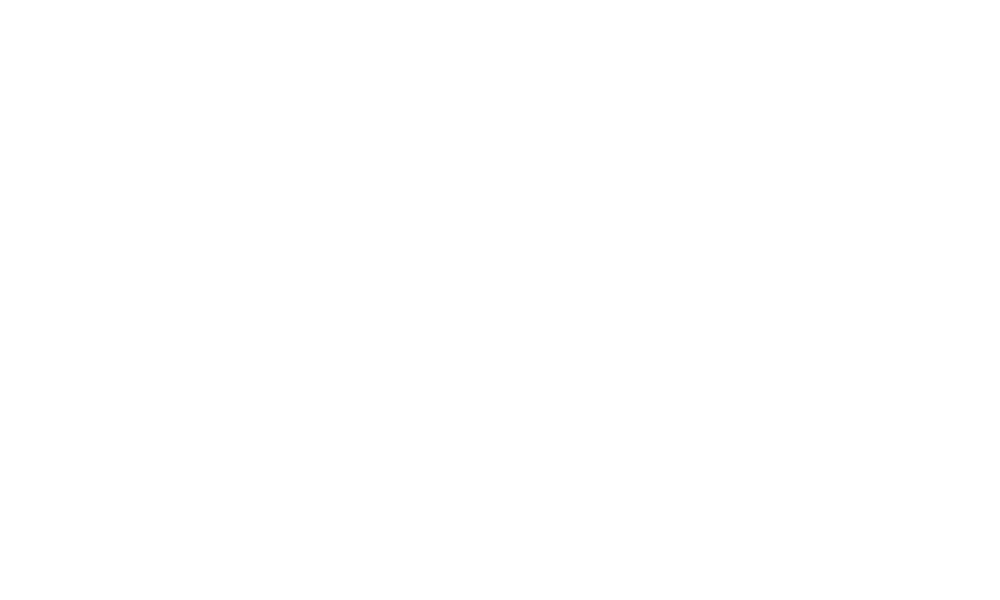

<IPython.core.display.Javascript object>


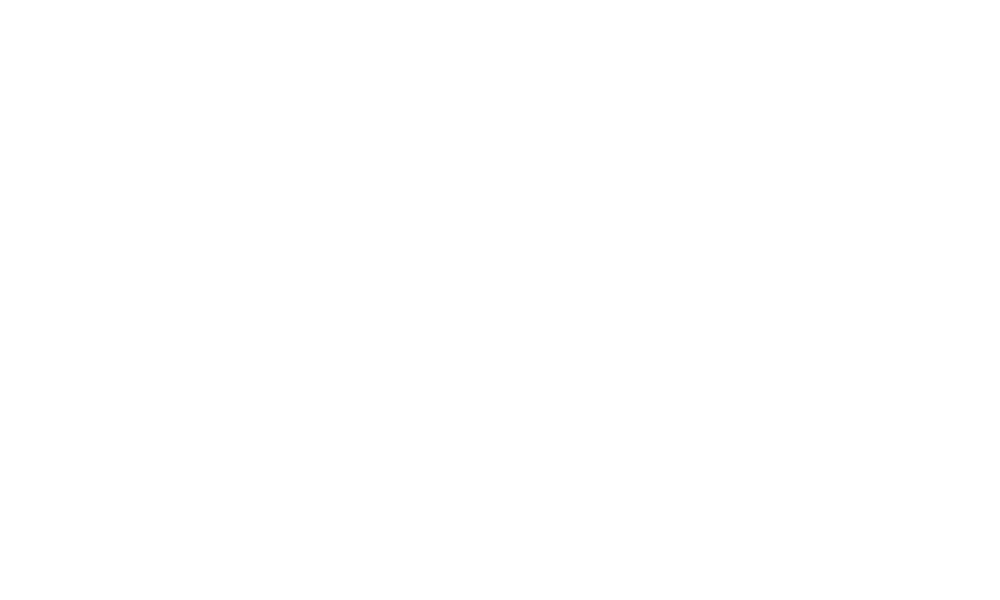

<IPython.core.display.Javascript object>


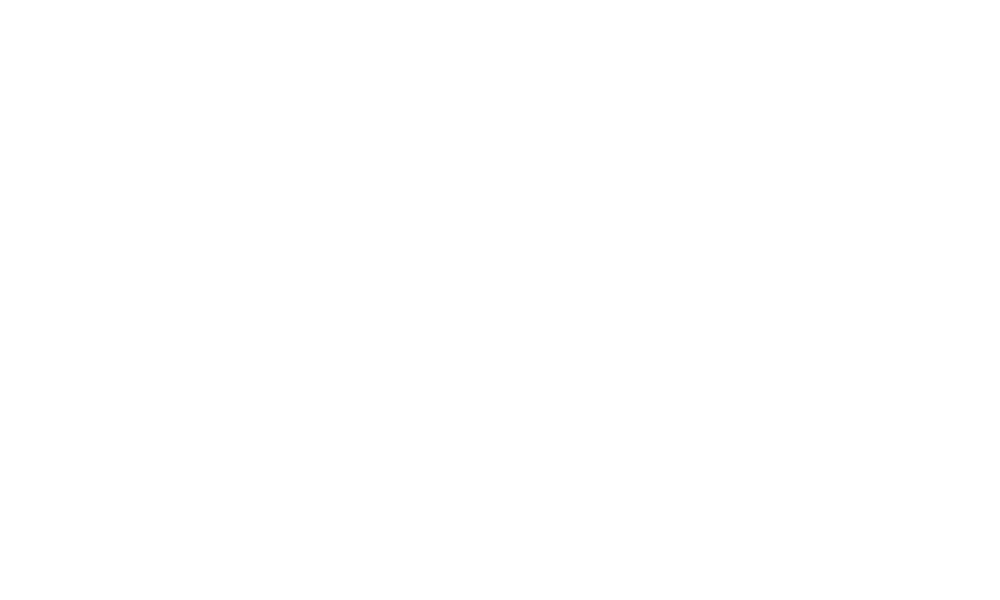

<IPython.core.display.Javascript object>


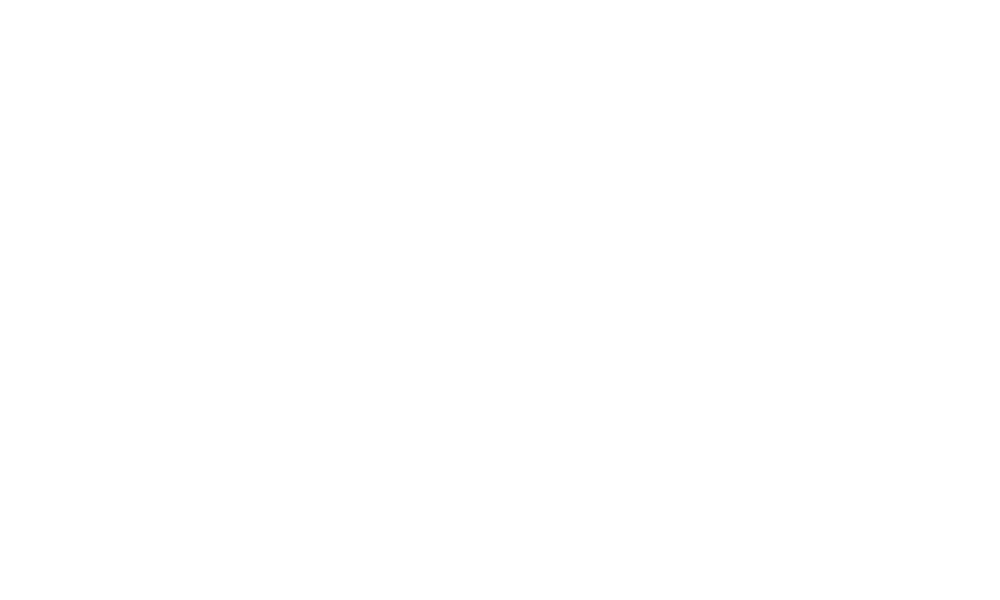

<IPython.core.display.Javascript object>


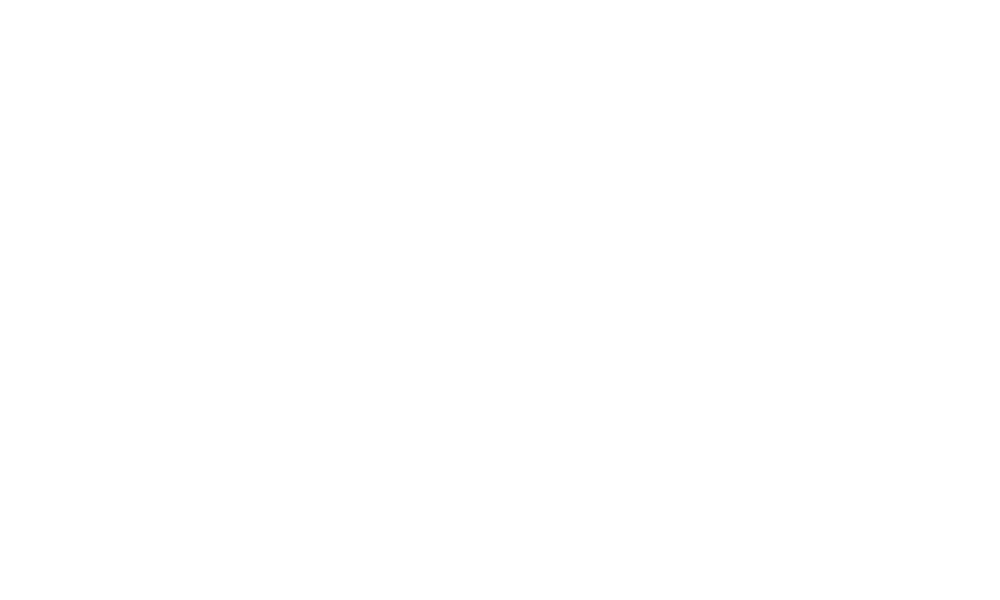

In [10]:
from io import BytesIO
from PIL import Image

"""
Radius_j = np.arange(16.5,17,0.1)
theta_i = np.arange(10,30)
"""
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 2.0
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5
plt.rcParams["figure.subplot.wspace"] = 0.4
def render_frame(angle):
    global x , y , z , z2
    fig = plt.figure(figsize=(10.0, 6.0))
    ax = fig.add_subplot(1,2,1,projection='3d')

    #グラフタイトルを設定
    ax.set_title("Center Frequency",size=20)

    #軸ラベルのサイズと色を設定
    ax.set_xlabel("Radius[mm]",size=10,color="black")
    ax.set_ylabel("angle[Degree]",size=10,color="black")
    ax.set_zlabel("Center Frequency[GHz]",size=10,color="black")
    ax.view_init(10, angle)
    ax.set_xticks([15.5,16.0,16.5,17.0,17,5])
    ax.set_xticklabels([15.5,16.0,16.5,17.0,17,5])
    ax.set_yticks([20,25,30,35,40])
    ax.set_yticklabels([20,25,30,35,40])
    ax.set_zticks([3.3e9,3.4e9,3.5e9,3.6e9])
    ax.set_zticklabels([3.3,3.4,3.5,3.6])
    #numpyを使ってXYZの値を設定

    #散布図の作成
    ax.plot_surface(x,y,z.T,cmap="winter")
    #ax.plot_wireframe(x, y, z, c = "blue")
    #ax.contour3D(x, y, z, c = "blue")


    ax2 = fig.add_subplot(1,2,2,projection='3d')

    #グラフタイトルを設定
    ax2.set_title("NGD",size=20)

    #軸ラベルのサイズと色を設定
    ax2.set_xlabel("Radius[mm]",size=10,color="black")
    ax2.set_ylabel("angle[Degree]",size=10,color="black")
    ax2.set_zlabel("Group Delay[ns]",size=10,color="black")
    ax2.view_init(10, angle)
    ax2.set_xticks([15.5,16.0,16.5,17.0])
    ax2.set_xticklabels([15.5,16.0,16.5,17.0])
    ax2.set_yticks([20,25,30,35,40])
    ax2.set_yticklabels([20,25,30,35,40])
    ax2.set_zticks([-6.5,-7.0,-7.5,-8])
    ax2.set_zticklabels([-6.5,-7.0,-7.5,-8.0])
    #numpyを使ってXYZの値を設定

    #散布図の作成
    ax2.plot_surface(x,y,z2.T,cmap="winter")
    #ax2.plot_wireframe(x, y, z2, c = "blue")
    #ax2.contour3D(x, y, z2, c = "blue")
    #描画
    plt.close()
    
    buf = BytesIO()

    fig.savefig(buf, bbox_inches='tight', pad_inches=1.0)
    return Image.open(buf)



images = [render_frame(angle) for angle in range(90,180)]
images[0].save('output.gif', save_all=True, append_images=images[1:], duration=100, loop=0)
